In [1]:
mc.cores = parallel::detectCores()
#rstan_options(auto_write = TRUE)

library(rethinking)

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.88)


In [2]:
sppnames <- c( "afarensis","africanus","habilis","boisei","rudolfensis","ergaster","sapiens")
brainvolcc <- c( 438 , 452 , 612, 521, 752, 871, 1350 )
masskg <- c( 37.0 , 35.5 , 34.5 , 41.5 , 55.5 , 61.0 , 53.5 )
d <- data.frame( species=sppnames , brain=brainvolcc , mass=masskg )

In [3]:
d

species,brain,mass
<fct>,<dbl>,<dbl>
afarensis,438,37.0
africanus,452,35.5
habilis,612,34.5
boisei,521,41.5
rudolfensis,752,55.5
ergaster,871,61.0
sapiens,1350,53.5


In [4]:
d$mass_std <- (d$mass - mean(d$mass))/sd(d$mass)
d$brain_std <- d$brain / max(d$brain)

In [5]:
m7.1 <- quap(
alist(
brain_std ~ dnorm( mu , exp(log_sigma) ),
mu <- a + b*mass_std,
a ~ dnorm( 0.5 , 1 ),
b ~ dnorm( 0 , 10 ),
log_sigma ~ dnorm( 0 , 1 )
), data=d )

precis(m7.1)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.5285430,0.06842565,0.4191856,0.6379004
b,0.1671092,0.07407970,0.0487155,0.2855028
log_sigma,-1.7067065,0.29378011,-2.1762239,-1.2371892


In [6]:
set.seed(12)
s <- sim( m7.1 )
r <- apply(s,2,mean) - d$brain_std
resid_var <- var2(r)
outcome_var <- var2( d$brain_std )
1 - resid_var/outcome_var

[1] 0.4774589

In [7]:
R2_is_bad <- function( quap_fit ) {
    s <- sim( quap_fit , refresh=0 )
    r <- apply(s,2,mean) - d$brain_std
    1 - var2(r)/var2(d$brain_std)
}

In [8]:
m7.2 <- quap(
alist(
brain_std ~ dnorm( mu , exp(log_sigma) ),
mu <- a + b[1]*mass_std + b[2]*mass_std^2,
a ~ dnorm( 0.5 , 1 ),
b ~ dnorm( 0 , 10 ),
log_sigma ~ dnorm( 0 , 1 )
), data=d , start=list(b=rep(0,2)) )

In [9]:
m7.3 <- quap(
alist(
brain_std ~ dnorm( mu , exp(log_sigma) ),
mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
b[3]*mass_std^3,
a ~ dnorm( 0.5 , 1 ),
b ~ dnorm( 0 , 10 ),
log_sigma ~ dnorm( 0 , 1 )
), data=d , start=list(b=rep(0,3)) )

m7.4 <- quap(
alist(
brain_std ~ dnorm( mu , exp(log_sigma) ),
mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
b[3]*mass_std^3 + b[4]*mass_std^4,
a ~ dnorm( 0.5 , 1 ),
b ~ dnorm( 0 , 10 ),
log_sigma ~ dnorm( 0 , 1 )
), data=d , start=list(b=rep(0,4)) )

m7.5 <- quap(
alist(
brain_std ~ dnorm( mu , exp(log_sigma) ),
mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
b[3]*mass_std^3 + b[4]*mass_std^4 +
b[5]*mass_std^5,
a ~ dnorm( 0.5 , 1 ),
b ~ dnorm( 0 , 10 ),
log_sigma ~ dnorm( 0 , 1 )
), data=d , start=list(b=rep(0,5)) )

In [10]:
m7.6 <- quap(
alist(
brain_std ~ dnorm( mu , 0.001 ),
mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
b[3]*mass_std^3 + b[4]*mass_std^4 +
b[5]*mass_std^5 + b[6]*mass_std^6,
a ~ dnorm( 0.5 , 1 ),
b ~ dnorm( 0 , 10 )
), data=d , start=list(b=rep(0,6)) )

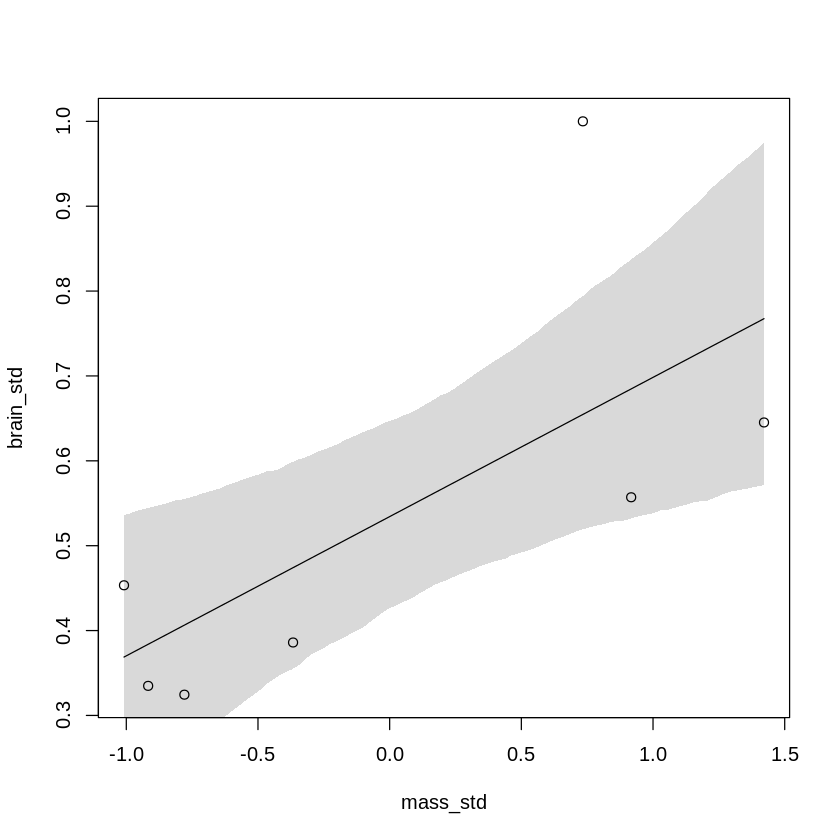

In [11]:
post <- extract.samples(m7.1)
mass_seq <- seq( from=min(d$mass_std) , to=max(d$mass_std) , length.out=100 )
l <- link( m7.1 , data=list( mass_std=mass_seq ) )
mu <- apply( l , 2 , mean )
ci <- apply( l , 2 , PI )
plot( brain_std ~ mass_std , data=d )
lines( mass_seq , mu )
shade( ci , mass_seq )

In [12]:
precis(m7.1)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.5285430,0.06842565,0.4191856,0.6379004
b,0.1671092,0.07407970,0.0487155,0.2855028
log_sigma,-1.7067065,0.29378011,-2.1762239,-1.2371892


In [13]:
plotFunc <- function(model) {

    post <- extract.samples(model)
    mass_seq <- seq( from=min(d$mass_std) , to=max(d$mass_std) , length.out=100 )
    l <- link( model , data=list( mass_std=mass_seq ) )
    mu <- apply( l , 2 , mean )
    ci <- apply( l , 2 , PI )
    plot( brain_std ~ mass_std , data=d )
    lines( mass_seq , mu )
    shade( ci , mass_seq )    
        
}

In [14]:
models <- c(m7.1, m7.2, m7.3, m7.4, m7.4, m7.5, m7.6)

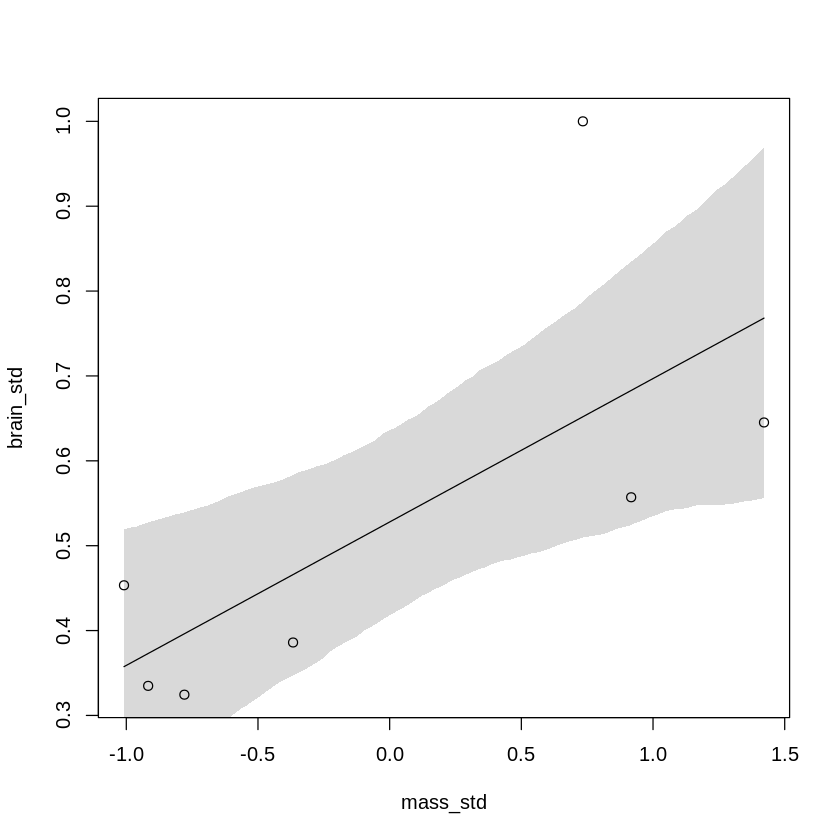

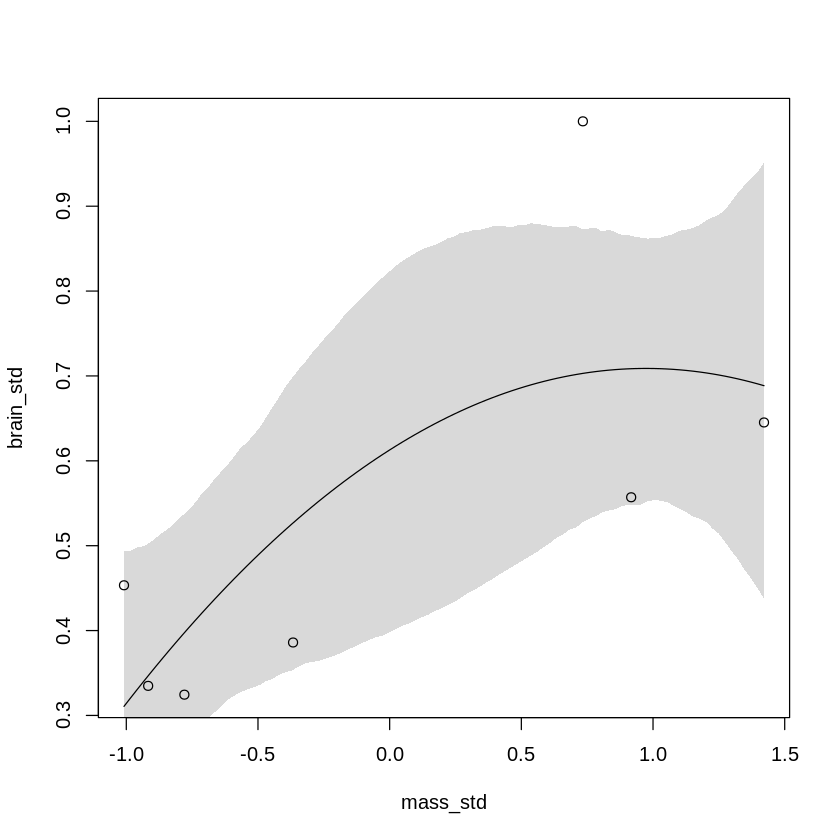

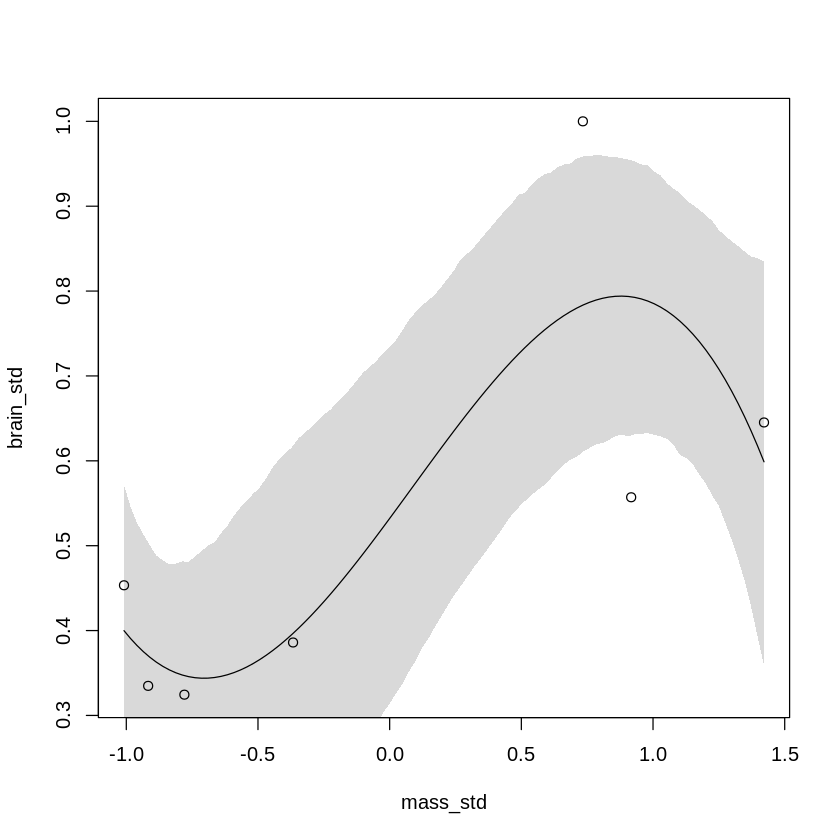

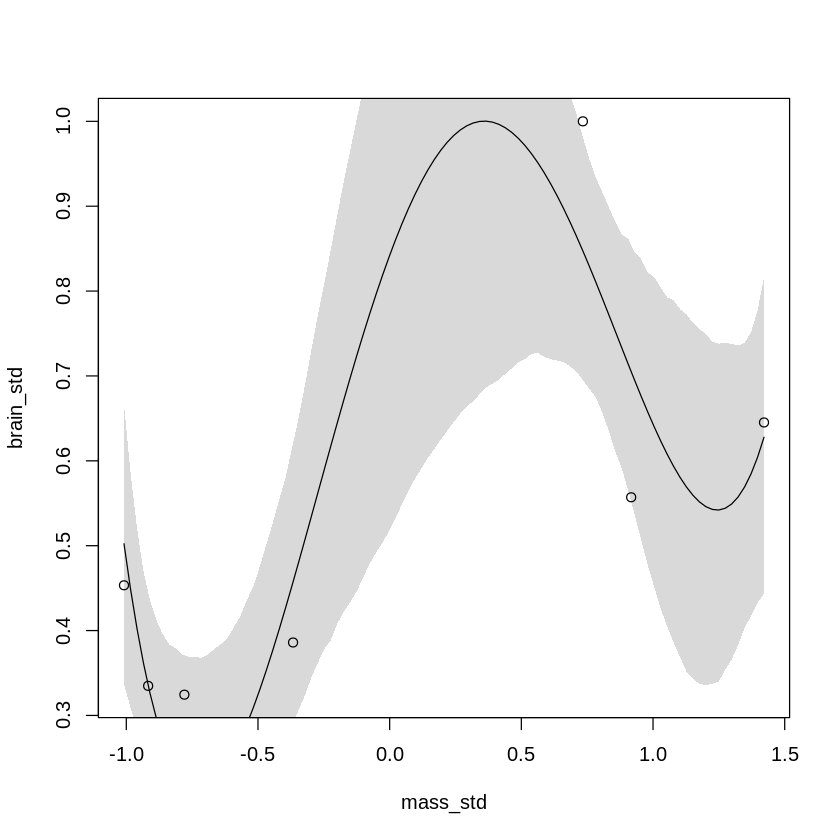

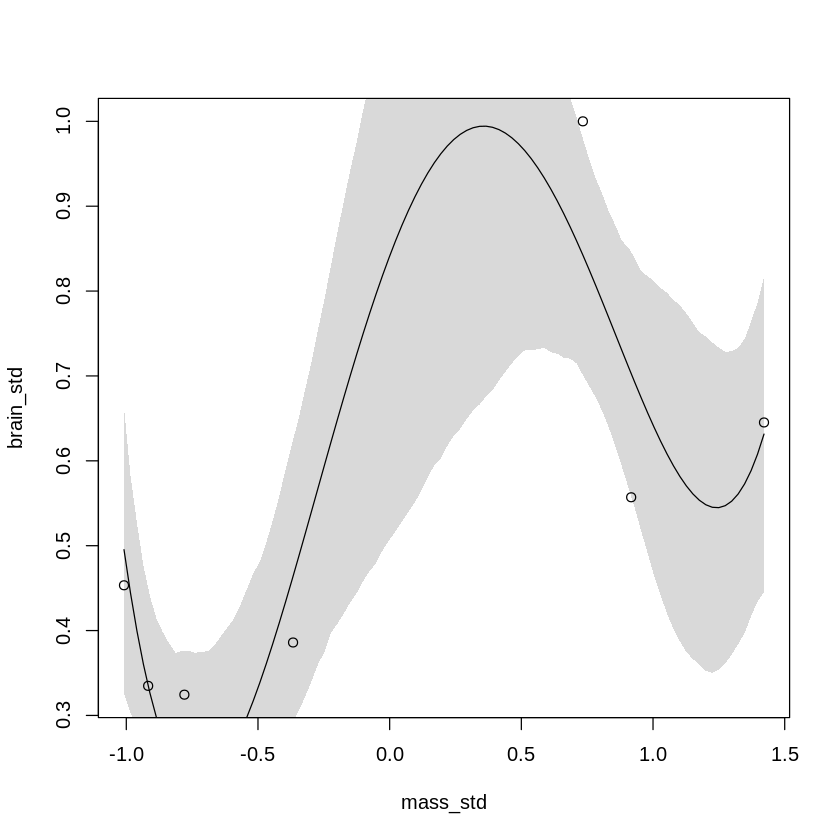

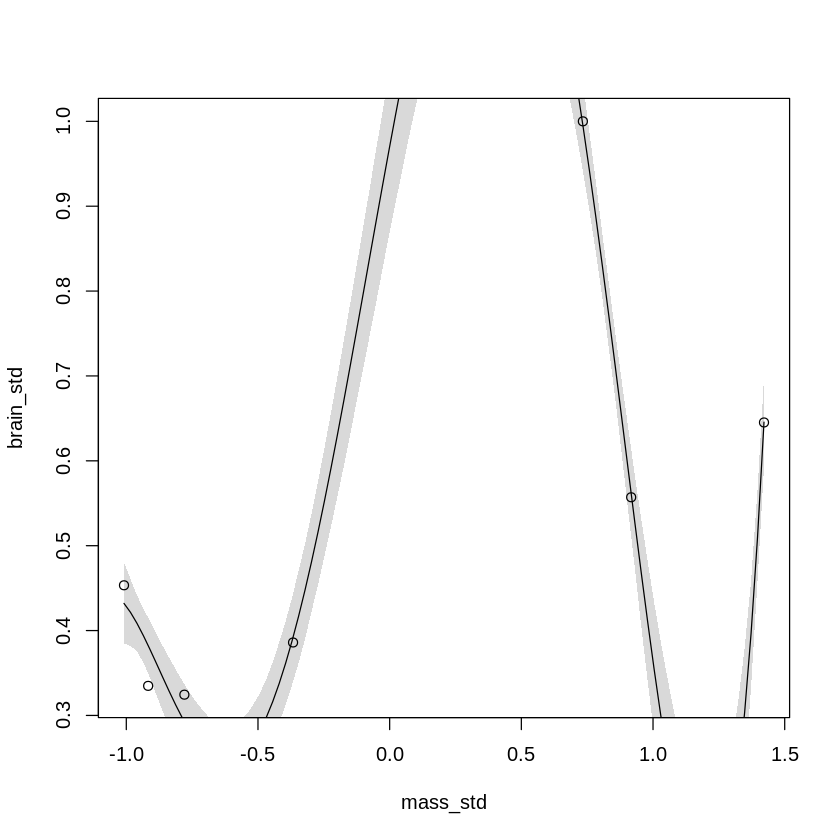

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

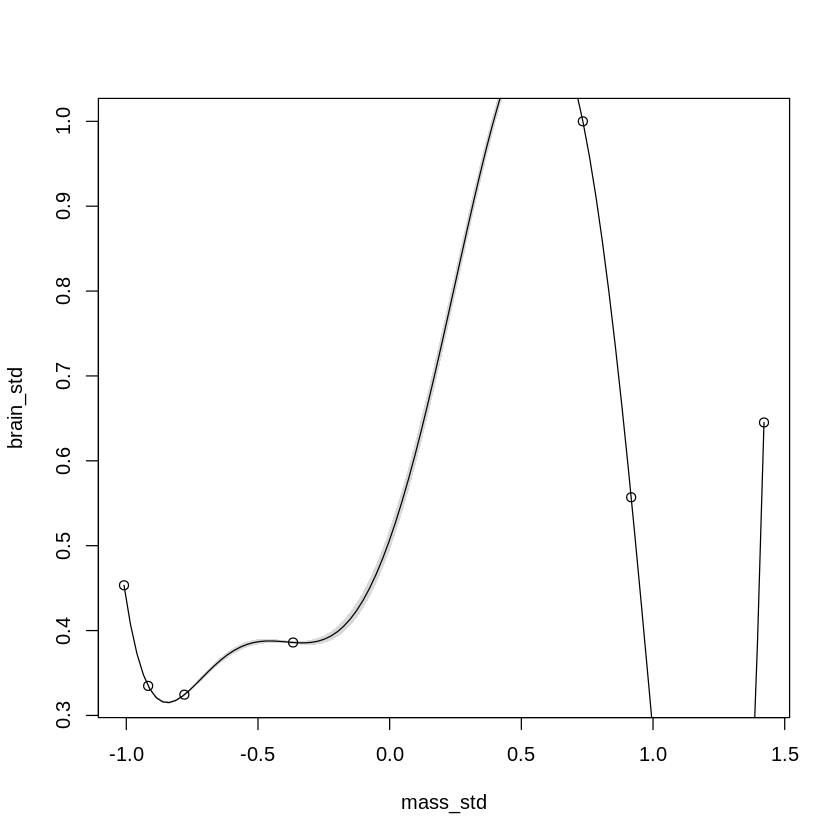

In [15]:
sapply( models, function(x) plotFunc(x) )

In [16]:
m7.6new <- quap(
alist(
brain_std ~ dnorm( mu , exp(log_sigma) ),
mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
b[3]*mass_std^3 + b[4]*mass_std^4 +
b[5]*mass_std^5 + b[6]*mass_std^6,
a ~ dnorm( 0.5 , 1 ),
b ~ dnorm( 0 , 10 ),
log_sigma ~ dnorm( 0 , 1 )
), data=d , start=list(b=rep(0,6)) )

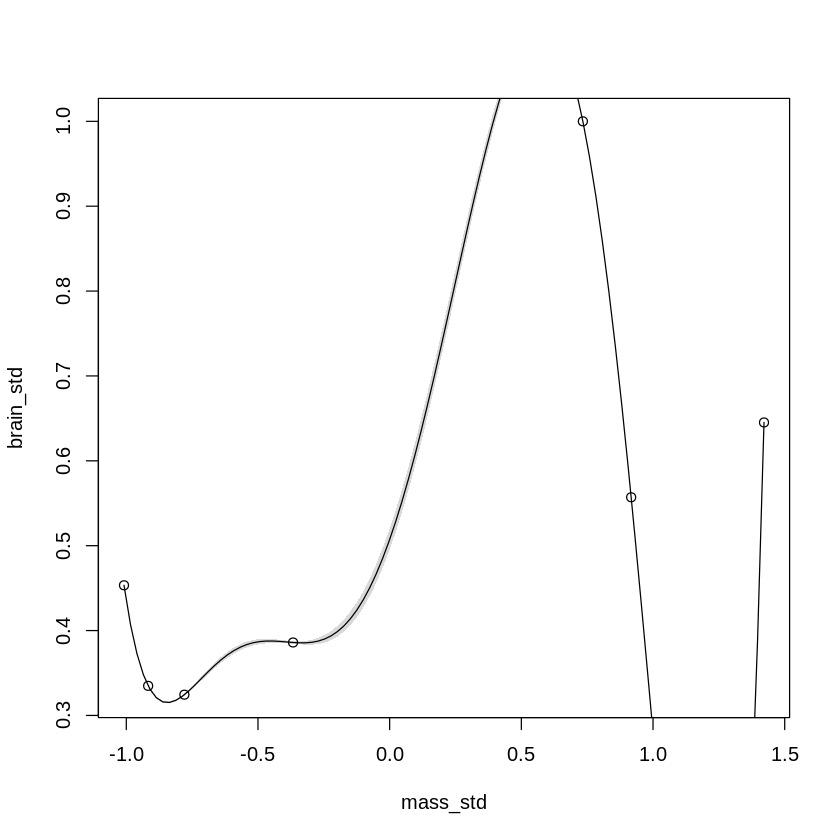

In [17]:
post <- extract.samples(m7.6new)
mass_seq <- seq( from=min(d$mass_std) , to=max(d$mass_std) , length.out=100 )
l <- link( m7.6new , data=list( mass_std=mass_seq ) )
mu <- apply( l , 2 , mean )
ci <- apply( l , 2 , PI )
plot( brain_std ~ mass_std , data=d )
lines( mass_seq , mu )
shade( ci , mass_seq )

In [18]:
brain_plot

function (fit, atx = c(35, 47, 60), aty = c(450, 900, 1300), 
    xlim, ylim, npts = 100) 
{
    R2 <- R2_is_bad(fit)
    if (is.nan(R2)) 
        R2 <- 1
    post <- extract.samples(fit)
    n <- dim(post$b)[2]
    if (is.null(n)) 
        n <- 1
    if (missing(xlim)) 
        xlim <- range(d$mass_std)
    else xlim <- (xlim - mean(d$mass))/sd(d$mass)
    if (missing(ylim)) 
        ylim <- range(d$brain_std)
    else ylim <- ylim/max(d$brain)
    plot(d$brain_std ~ d$mass_std, xaxt = "n", yaxt = "n", xlab = "body mass (kg)", 
        ylab = "brain volume (cc)", col = rangi2, pch = 16, xlim = xlim, 
        ylim = ylim)
    axis_unscale(1, atx, d$mass)
    axis_unscale(2, at = aty, factor = max(d$brain))
    xseq <- seq(from = xlim[1] - 0.2, to = xlim[2] + 0.2, length.out = npts)
    l <- link(fit, data = list(mass_std = xseq), refresh = 0)
    mu <- apply(l, 2, mean)
    lines(xseq, mu, lwd = 2)
    ci <- apply(l, 2, PI)
    shade(ci, xseq)
    model_name <- deparse(match.call()[[2]])
    mtext(concat(model_name, ": R^2 = ", round(R2, 2)), adj = 0)
}
<bytecode: 0x55a580eae730>
<environment: namespace:rethinking>

In [19]:
m7.1_OLS <- lm( brain_std ~ mass_std , data=d )
post <- extract.samples( m7.1_OLS )

In [20]:
precis(m7.1_OLS)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.5286772,0.07056924,0.41589398,0.6414605
mass_std,0.1671183,0.07622349,0.04529848,0.2889382


In [21]:
precis(m7.1)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.5285430,0.06842565,0.4191856,0.6379004
b,0.1671092,0.07407970,0.0487155,0.2855028
log_sigma,-1.7067065,0.29378011,-2.1762239,-1.2371892


In [22]:
m7.7 <- quap(
alist(
brain_std ~ dnorm( mu , exp(log_sigma) ),
mu <- a,
a ~ dnorm( 0.5 , 1 ),
log_sigma ~ dnorm( 0 , 1 )
), data=d )

In [23]:
precis(m7.7)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.5284294,0.0929683,0.3798481,0.6770107
log_sigma,-1.3982025,0.2862572,-1.8556968,-0.9407081


In [24]:
brain_loo_plot

function (fit, atx = c(35, 47, 60), aty = c(450, 900, 1300), 
    xlim, ylim, npts = 100) 
{
    post <- extract.samples(fit)
    n <- dim(post$b)[2]
    if (is.null(n)) 
        n <- 1
    if (missing(xlim)) 
        xlim <- range(d$mass_std)
    else xlim <- (xlim - mean(d$mass))/sd(d$mass)
    if (missing(ylim)) 
        ylim <- range(d$brain_std)
    else ylim <- ylim/max(d$brain)
    plot(d$brain_std ~ d$mass_std, xaxt = "n", yaxt = "n", xlab = "body mass (kg)", 
        ylab = "brain volume (cc)", col = rangi2, pch = 16, xlim = xlim, 
        ylim = ylim)
    axis_unscale(1, atx, d$mass)
    axis_unscale(2, at = aty, factor = max(d$brain))
    d <- as.data.frame(fit@data)
    for (i in 1:nrow(d)) {
        di <- d[-i, ]
        m_temp <- quap(fit@formula, data = di, start = list(b = rep(0, 
            n)))
        xseq <- seq(from = xlim[1] - 0.2, to = xlim[2] + 0.2, 
            length.out = npts)
        l <- link(m_temp, data = list(mass_std = xseq), refresh = 0)
        mu <- apply(l, 2, mean)
        lines(xseq, mu, lwd = 2, col = col.alpha("black", 0.3))
    }
    model_name <- deparse(match.call()[[2]])
    mtext(model_name, adj = 0)
}
<bytecode: 0x55a583d8fa10>
<environment: namespace:rethinking>

In [25]:
p <- c( 0.3 , 0.7 )
-sum( p*log(p) )

[1] 0.6108643

In [26]:
p <- c( 0.01 , 0.99 )
-sum( p*log(p) )

[1] 0.05600153

In [27]:
p <- c( 0.7 , 0.15, 0.15 )
-sum( p*log(p) )

[1] 0.8188085

In [28]:
d

species,brain,mass,mass_std,brain_std
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
afarensis,438,37.0,-0.7794667,0.3244444
africanus,452,35.5,-0.9170196,0.3348148
habilis,612,34.5,-1.0087216,0.4533333
boisei,521,41.5,-0.3668079,0.3859259
rudolfensis,752,55.5,0.9170196,0.5570370
ergaster,871,61.0,1.4213804,0.6451852
sapiens,1350,53.5,0.7336157,1.0000000


In [29]:
set.seed(1)
lppd( m7.1 , n=1e4 )

[1]  0.6098668  0.6483438  0.5496093  0.6234934  0.4648143  0.4347605 -0.8444632

In [30]:
set.seed(1)
logprob <- sim( m7.1 , ll=TRUE , n=1e4 )
n <- ncol(logprob)
ns <- nrow(logprob)
f <- function( i ) log_sum_exp( logprob[,i] ) - log(ns)
( lppd <- sapply( 1:n , f ) )

[1]  0.6098668  0.6483438  0.5496093  0.6234934  0.4648143  0.4347605 -0.8444632

In [31]:
logprob

0.56336207,0.7001153,0.9653883,0.65937392,0.80852165,0.91167090,-2.136949983
0.42058899,0.5069911,0.7337400,0.51476475,0.66756997,0.72433402,-1.334647709
0.83340940,0.9220778,0.9443597,0.92656693,1.03051515,1.00785925,-3.968635146
0.31857598,0.3183601,0.2070566,0.31700179,0.27274889,0.20834642,-1.452839668
0.31308583,0.4259733,0.6880982,0.34633240,0.36342723,0.44840711,-0.473022785
0.85190187,0.9494457,0.8960931,0.88584214,0.90916136,0.97614914,-2.841470676
0.64429110,0.6302528,0.3255861,0.64404588,0.64392286,0.64396287,-1.787354174
0.48013545,0.5379179,0.5091302,0.43402669,0.15236062,0.09462220,-0.166766864
0.06019873,0.2014849,0.5740498,0.06077281,-0.04078740,0.02758943,0.078133996
0.82996452,0.8770248,0.5342144,0.70613888,-0.35360889,-0.79599297,-0.087081229
0.26298819,0.3068873,0.3214765,0.23508460,0.07179661,0.04717760,-0.110941775


In [32]:
set.seed(1)
sapply( list(m7.1,m7.2,m7.3,m7.4,m7.5,m7.6) , function(m) sum(lppd(m)) )

[1]  2.490390  2.566165  3.741488  5.333750 14.124459 39.445390

In [38]:
N <- 20
kseq <- 1:5
dev <- sapply( kseq , function(k) {
    print(k);
    #r <- replicate( 1e2 , sim_train_test( N=N, k=k ) );
    r <- mcreplicate( 1e2 , sim_train_test( N=N, k=k ) , mc.cores=4 )
    c( mean(r[1,]) , mean(r[2,]) , sd(r[1,]) , sd(r[2,]) )
} )

[1] 1

[1] 2

[1] 3

[1] 4

[1] 5



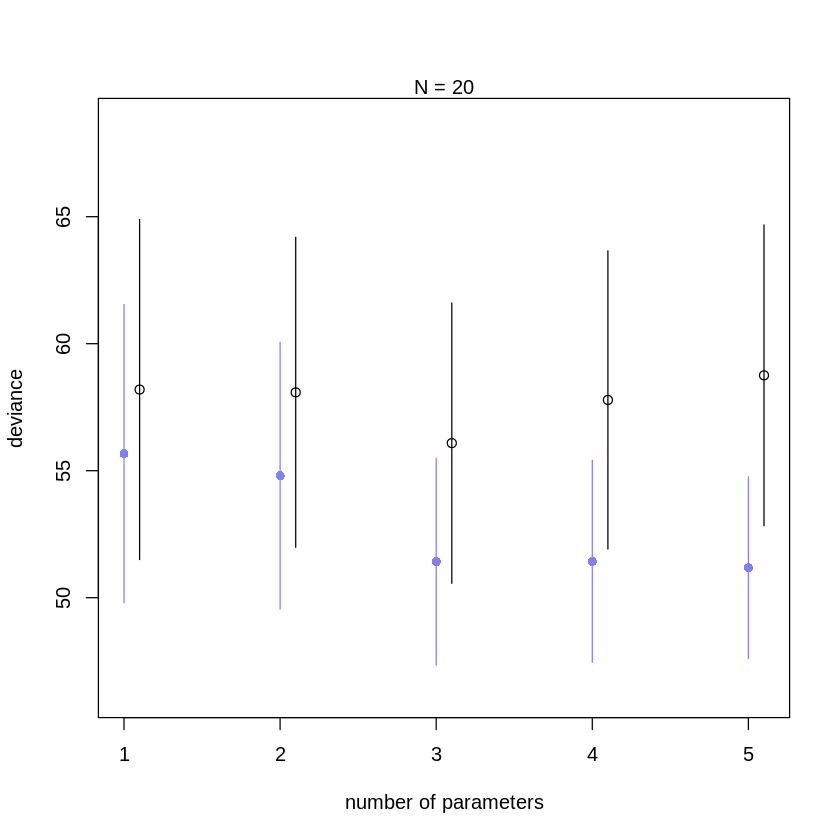

In [40]:
plot( 1:5, dev[1,], ylim=c(min(dev[1:2,])-5, max(dev[1:2,])+10),
    xlim=c(1,5.1) , xlab="number of parameters" , ylab="deviance" ,
    pch=16 , col=rangi2 )
mtext( concat( "N = ",N ) )
points( (1:5)+0.1 , dev[2,] )
for ( i in kseq ) {
    pts_in <- dev[1,i] + c(-1,+1)*dev[3,i]
    pts_out <- dev[2,i] + c(-1,+1)*dev[4,i]
    lines( c(i,i) , pts_in , col=rangi2 )
    lines( c(i,i)+0.1 , pts_out )
}

In [41]:
data(cars)
m <- quap(
        alist(
            dist ~ dnorm(mu,sigma),
            mu <- a + b*speed,
            a ~ dnorm(0,100),
            b ~ dnorm(0,10),
            sigma ~ dexp(1)
        ) , data=cars )
set.seed(94)
post <- extract.samples(m,n=1000)

In [42]:
n_samples <- 1000
logprob <- sapply( 1:n_samples ,
    function(s) {
    mu <- post$a[s] + post$b[s]*cars$speed
    dnorm( cars$dist , mu , post$sigma[s] , log=TRUE )
} )

In [43]:
n_cases <- nrow(cars)
lppd <- sapply( 1:n_cases , function(i) log_sum_exp(logprob[i,]) - log(n_samples) )

In [44]:
sum(lppd)

[1] -206.8787

In [45]:
pWAIC <- sapply( 1:n_cases , function(i) var(logprob[i,]) )

In [46]:
-2*( sum(lppd) - sum(pWAIC) )

[1] 423.3188

In [47]:
waic_vec <- -2*( lppd - pWAIC )
sqrt( n_cases*var(waic_vec) )

[1] 17.81797

In [48]:
WAIC(m)

[1] 422.1024
attr(,"lppd")
[1] -206.8781
attr(,"pWAIC")
[1] 4.173077
attr(,"se")
[1] 16.9881

In [49]:
data(Primates301)
d <- Primates301

In [50]:
head(d)

name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NA,1,1,0,6,58.02,4655.00,40.0,NA,106.15,276.0,NA,NA
Allocebus_trichotis,Allocebus,trichotis,NA,2,2,0,6,NA,78.09,1.0,NA,NA,NA,NA,NA
Alouatta_belzebul,Alouatta,belzebul,NA,3,3,0,15,52.84,6395.00,7.4,NA,NA,NA,NA,NA
Alouatta_caraya,Alouatta,caraya,NA,4,3,0,45,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
Alouatta_guariba,Alouatta,guariba,NA,5,3,0,37,51.70,5175.00,7.4,NA,NA,NA,NA,NA
Alouatta_palliata,Alouatta,palliata,NA,6,3,3,79,49.88,6250.00,13.1,185.42,495.60,300.0,1578.42,681.02


In [51]:
d$log_L <- scale( log(d$longevity) )
d$log_B <- scale( log(d$brain) )
d$log_M <- scale( log(d$body) )
head(d)

name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment,log_L,log_B,log_M
<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NA,1,1,0,6,58.02,4655.00,40.0,NA,106.15,276.0,NA,NA,-0.21610838,0.3725906,0.4260120
Allocebus_trichotis,Allocebus,trichotis,NA,2,2,0,6,NA,78.09,1.0,NA,NA,NA,NA,NA,NA,NA,-2.0883257
Alouatta_belzebul,Alouatta,belzebul,NA,3,3,0,15,52.84,6395.00,7.4,NA,NA,NA,NA,NA,NA,0.2977140,0.6213451
Alouatta_caraya,Alouatta,caraya,NA,4,3,0,45,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08,-0.51173084,0.2945257,0.5153852
Alouatta_guariba,Alouatta,guariba,NA,5,3,0,37,51.70,5175.00,7.4,NA,NA,NA,NA,NA,NA,0.2802512,0.4911471
Alouatta_palliata,Alouatta,palliata,NA,6,3,3,79,49.88,6250.00,13.1,185.42,495.60,300.0,1578.42,681.02,-0.01871253,0.2515576,0.6072383


In [52]:
sapply( d[,c("log_L","log_B","log_M")] , function(x) sum(is.na(x)) )

log_L log_B log_M 
  181   117    63

In [53]:
d2 <- d[ complete.cases( d$log_L , d$log_M , d$log_B ) , ]
nrow(d2)

[1] 112

In [54]:
m7.8 <- quap(
alist(
log_L ~ dnorm( mu , sigma ),
mu <- a + bM*log_M + bB*log_B,
a ~ dnorm(0,0.1),
bM ~ dnorm(0,0.5),
bB ~ dnorm(0,0.5),
sigma ~ dexp(1)
) , data=d2 )

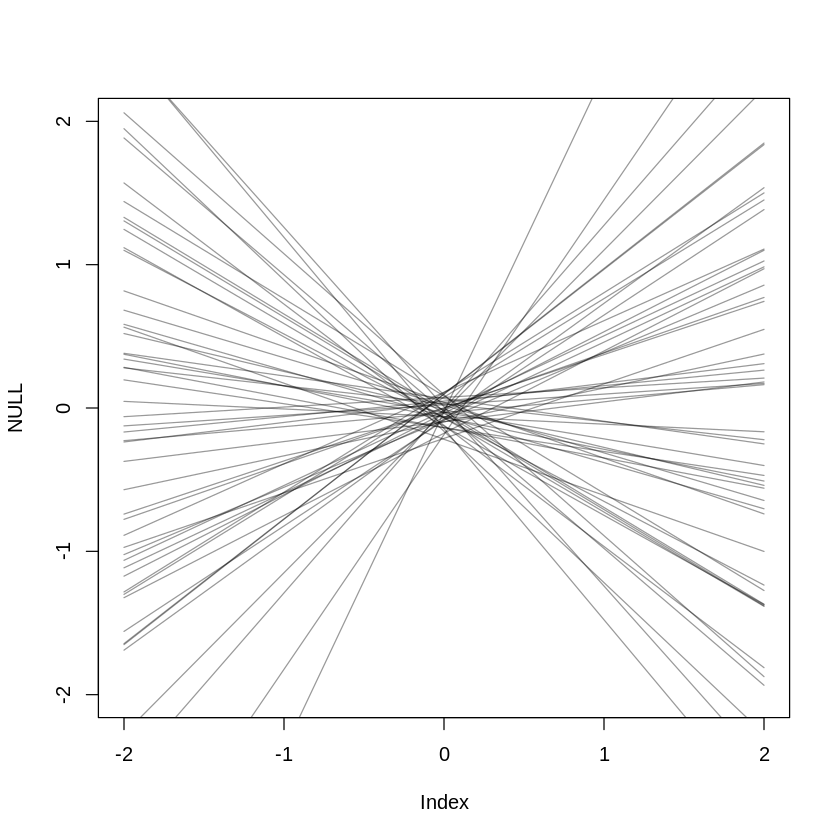

In [55]:
set.seed(10)
prior <- extract.prior( m7.8 )
xseq <- c(-2,2)
mu <- link( m7.8 , post=prior , data=list(log_M=xseq, log_B=xseq) )
plot( NULL , xlim=xseq , ylim=xseq )
for ( i in 1:50 ) lines( xseq , mu[i,] , col=col.alpha("black",0.4) )

In [56]:
m7.9 <- quap(
alist(
    log_L ~ dnorm( mu , sigma ),
    mu <- a + bB*log_B,
    a ~ dnorm(0,0.1),
    bB ~ dnorm(0,0.5),
    sigma ~ dexp(1)
) , data=d2 )

m7.10 <- quap(
alist(
    log_L ~ dnorm( mu , sigma ),
    mu <- a + bM*log_M,
    a ~ dnorm(0,0.1),
    bM ~ dnorm(0,0.5),
    sigma ~ dexp(1)
) , data=d2 )

In [57]:
set.seed(301)
compare( m7.8 , m7.9 , m7.10 )

,WAIC,pWAIC,dWAIC,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m7.8,216.2302,3.472769,0.0000000,0.5330064119,14.72038,NA
m7.9,216.4978,2.603078,0.2675944,0.4662566680,14.83716,1.502932
m7.10,229.3978,2.465454,13.1676184,0.0007369201,16.30344,7.002148


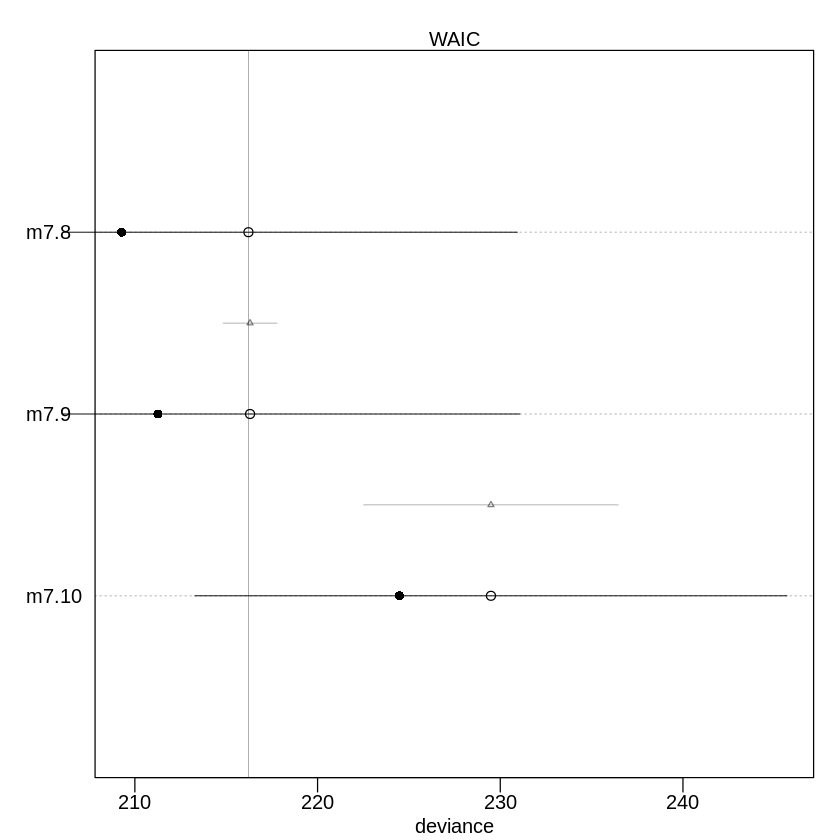

In [58]:
plot( compare( m7.8 , m7.9 , m7.10 ) )

In [59]:
precis(m7.8)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-0.03489991,0.05123489,-0.1167832,0.04698335
bM,-0.18935745,0.22944933,-0.5560618,0.17734689
bB,0.85448149,0.22118736,0.5009814,1.20798161
sigma,0.61382718,0.04114361,0.5480717,0.67958262


In [60]:
precis(m7.9)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-0.04313322,0.05055135,-0.1239240,0.03765761
bB,0.67804076,0.05710782,0.5867714,0.76931009
sigma,0.61884585,0.04120378,0.5529943,0.68469745


In [61]:
precis(m7.10)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-0.06816089,0.05298940,-0.1528482,0.0165264
bM,0.66576311,0.06277522,0.5654362,0.7660900
sigma,0.65613340,0.04371354,0.5862707,0.7259961


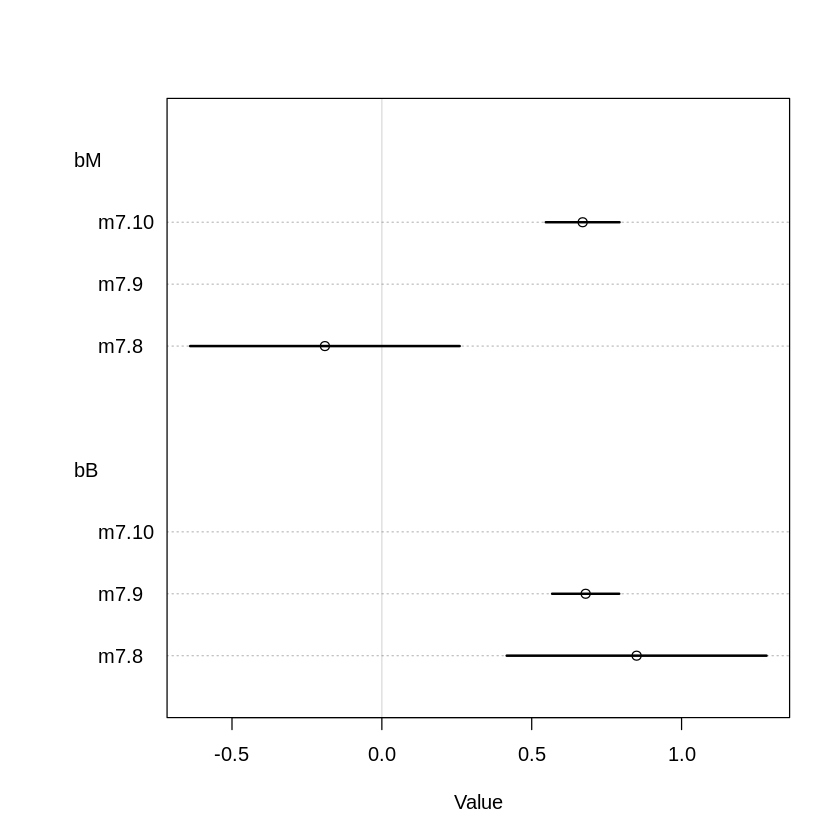

In [62]:
plot( coeftab( m7.8 , m7.9 , m7.10 ) , pars=c("bM","bB") )

In [63]:
cor( d2$log_B , d2$log_M )

0.9796272


In [64]:
d['BPG'] = scale(d['brain']/d['body'])
d['log_BPG'] = scale(log(d['brain']/d['body']))

In [65]:
head(d)

name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,⋯,gestation,weaning,longevity,sex_maturity,maternal_investment,log_L,log_B,log_M,BPG,log_BPG
<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NA,1,1,0,6,58.02,4655.00,⋯,NA,106.15,276.0,NA,NA,-0.21610838,0.3725906,0.4260120,-0.3350480,-0.1527707
Allocebus_trichotis,Allocebus,trichotis,NA,2,2,0,6,NA,78.09,⋯,NA,NA,NA,NA,NA,NA,NA,-2.0883257,NA,NA
Alouatta_belzebul,Alouatta,belzebul,NA,3,3,0,15,52.84,6395.00,⋯,NA,NA,NA,NA,NA,NA,0.2977140,0.6213451,-0.9680138,-1.0821637
Alouatta_caraya,Alouatta,caraya,NA,4,3,0,45,52.63,5383.00,⋯,185.92,323.16,243.6,1276.72,509.08,-0.51173084,0.2945257,0.5153852,-0.7398601,-0.7017005
Alouatta_guariba,Alouatta,guariba,NA,5,3,0,37,51.70,5175.00,⋯,NA,NA,NA,NA,NA,NA,0.2802512,0.4911471,-0.7077302,-0.6529174
Alouatta_palliata,Alouatta,palliata,NA,6,3,3,79,49.88,6250.00,⋯,185.42,495.60,300.0,1578.42,681.02,-0.01871253,0.2515576,0.6072383,-1.0104854,-1.1606431


In [66]:
d2 <- d[ complete.cases( d$log_L , d$log_M , d$log_B ) , ]
nrow(d2)

m7.10b <- quap(
    alist(
    log_L ~ dnorm( mu , sigma ),
    mu <- a + bBPG*log_BPG,
    a ~ dnorm(0,0.1),
    bBPG ~ dnorm(0,0.5),
    sigma ~ dexp(1)
) , data=d2 )

[1] 112

In [67]:
precis(m7.10b)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.01315138,0.06265842,-0.08698888,0.1132916
bBPG,-0.39229912,0.08086810,-0.52154197,-0.2630563
sigma,0.84540447,0.05617916,0.75561932,0.9351896


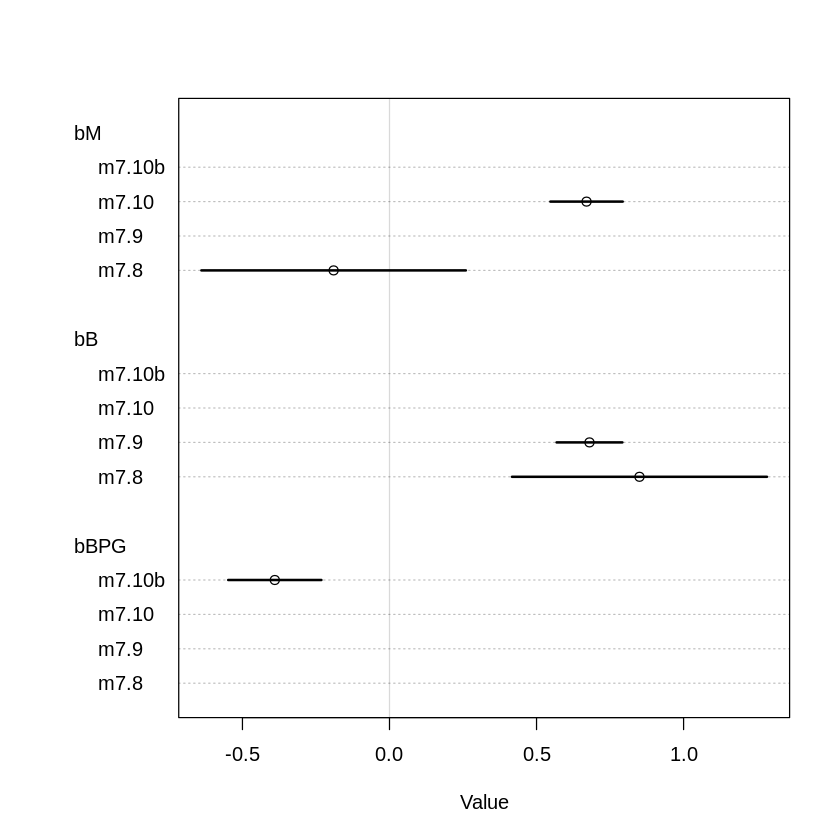

In [68]:
plot( coeftab( m7.8 , m7.9 , m7.10, m7.10b ) , pars=c("bM","bB","bBPG") )

In [69]:
waic_m7.8 <- WAIC( m7.8 , pointwise=TRUE )
waic_m7.9 <- WAIC( m7.9 , pointwise=TRUE )

In [70]:
str(waic_m7.8)

 num [1:112] 1.349 1.96 0.904 1.874 0.946 ...
 - attr(*, "lppd")= num [1:112] -0.668 -0.965 -0.446 -0.892 -0.467 ...
 - attr(*, "pWAIC")= num [1:112] 0.00585 0.01454 0.00557 0.04526 0.00587 ...
 - attr(*, "se")= num 14.7


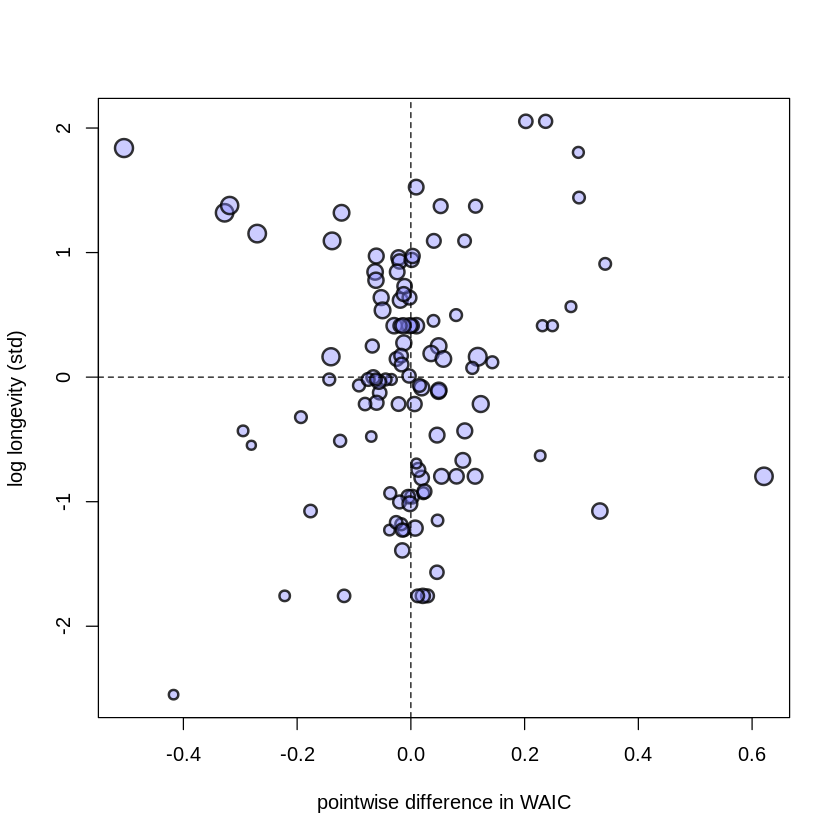

In [71]:
#compute point scaling
x <- d2$log_B - d2$log_M
x <- x - min(x)
x <- x / max(x)

# draw the plot
plot( waic_m7.8 - waic_m7.9 , d2$log_L ,
xlab="pointwise difference in WAIC" , ylab="log longevity (std)" , pch=21 ,
col=col.alpha("black",0.8) , cex=1+x , lwd=2 , bg=col.alpha(rangi2,0.4) )
abline( v=0 , lty=2 )
abline( h=0 , lty=2 )

In [72]:
m7.11 <- quap(
    alist(
    log_B ~ dnorm( mu , sigma ),
    mu <- a + bM*log_M + bL*log_L,
    a ~ dnorm(0,0.1),
    bM ~ dnorm(0,0.5),
    bL ~ dnorm(0,0.5),
    sigma ~ dexp(1)
) , data=d2 )

precis( m7.11 )

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-0.04508898,0.01795354,-0.07378221,-0.01639575
bM,0.93842052,0.02602529,0.89682708,0.98001395
bL,0.11549722,0.02723899,0.07196405,0.15903038
sigma,0.18997441,0.01267723,0.16971376,0.21023507


In [73]:
#?ensemble

In [74]:
#?compare

Practice Questions

Easy

1. Uncertainty should be continuous, increase with size of outcome space, and be additive.

In [75]:
-(0.3*log(0.3) + 0.7*log(0.7))

[1] 0.6108643

In [76]:
-(0.2*log(0.2) + 0.5*log(0.25) + 0.3*log(0.3))

[1] 1.376227

In [77]:
-(log(1/3))

[1] 1.098612

Medium

AIC = Dtrain + 2p = -2 lppd + 2p,

where p is number of parameters (or dimensions of posterior) and D is deviance (= -2 * lppd, where lppd is the log pointwise posterior density: sum_i (log (sum_j p(y_i | theta_j) ) ), where i indexes observation y and j indexes parameters sample j from the posterior distribution ). 

AIC is an approximation that is reliable only when:
(1) The priors are flat or overwhelmed by the likelihood.
(2) The posterior distribution is approximately multivariate Gaussian.
(3) The sample size N is much greater than the number of parameters k

DIC accommodates informative priors, but still assumes that the posterior is multivariate Gaussian and
that N ≫ k.

WAIC = -2lppd + sum_i(var_Θ( log ( p (y_i | Θ) ) )),

where y_i is the i'th observation and Θ is the posterior distribution of y_i. The penalty term means, “compute the variance in log-probabilities for each observation i, and then sum up these variances to get the total penalty.” So you can think of each observation as having its own personal penalty score. And since these scores measure overfitting risk, you can also assess overfitting risk at the level of each observation.

WAIC makes no assumptions about the posterior distribution.

All three definitions involve two components: an estimate or analog of the in-sample training deviance (i.e., Dtrain for AIC, D¯ for DIC, and lppd for WAIC) and an estimate or analog for the number of free parameters estimated in the model (i.e., p in AIC, pD in DIC, and pWAIC in WAIC).

WAIC is the most general, followed by DIC, and finally AIC. To move from WAIC to DIC, we must assume that the posterior distribution is approximately multivariate Gaussian. To move from DIC to AIC, we must further assume that the priors are flat or overwhelmed by the likelihood.

<b>Model selection</b>: choose the model with the best 'fit' and throw away all the other models.  The fit may be done with any goodness-of-fit measure, such as WAIC or LOOIS.  Some models may be better at explaining subsets of the data than others.  Given that the best fit model only fits the best on average, we throw away the better fit available for subsets of data.

You should never do model selection. This kind of selection procedure discards the information about relative
model accuracy contained in the differences among the LOOCV/LOOIS/WAIC values. Why
are the differences useful? Because sometimes the differences are large and sometimes they
are small. Just as relative posterior probability provides advice about how confident we might
be about parameters (conditional on the model), relative model accuracy provides advice
about how confident we might be about models (conditional on the set of models compared).

Another reason to never select models based upon WAIC/LOOCV/LOOIS alone is that
we might care about causal inference. Maximizing expected predictive accuracy is not the
same as inferring causation. Highly confounded models can still make good predictions,
at least in the short term. They won’t tell us the consequences of an intervention, but they
might help us forecast. So we need to be clear about our goals.

So what good are these criteria then? They measure expected predictive value of a variable on the right scale, accounting for overfitting. They also provide a way to measure the
overfitting tendency of a model, and that helps us both design models and understand how
statistical inference works. Finally, minimizing a criterion like WAIC can help in designing
models, especially in tuning parameters in multilevel models.

<b>Model averaging</b>: take the average of predictions from a set of models.  Model averaging is a family of methods for
combining the predictions of multiple models.  I suppose this allows greater flexibility of the 'ensemble model' to fit to the data, increasing the effective number of parameters.  What information is lost doing this?

From (https://jmgirard.com/statistical-rethinking-ch6/): "Model selection is choosing to retain (e.g., use and interpret) the model with the lowest information criterion value and to discard all other models with higher values (page 195). This practice loses information about relative model accuracy contained in the differences among information criterion values; this is especially problematic when the selected model only outperforms its alternatives to a small degree. Model averaging is using Bayesian information criteria to construct a posterior predictive distribution (i.e., make predictions) that leverages the uncertainty in multiple models (page 196). This practice does not lose information on its own. However, when combined with undisclosed data dredging (page 205), it can lead to spurious findings (e.g., non-generalizable coincidence)."

6M3: When comparing models with an information criterion, why must all models be fit to exactly
the same observations? What would happen to the information criterion values, if the models were
fit to different numbers of observations? Perform some experiments, if you are not sure.

If models are fit with different observations, it is not a fair test of the models.  Some models may fit different subsets of the data better.

If different numbers of observations are used, this would mess up the comparison, because the deviance scales with the number of observations (because it involves a sum over all the observations), hence the information criteria would be affected by the scaling.  Models with fewer observations have an "easier job," and therefore have lower (better) information criterion, as deviance (and therefore information criteria) is an additive measure of error.


From (https://jmgirard.com/statistical-rethinking-ch6/): "Information criteria are based on deviance, which is accrued over observations without being divided by the number of observations (page 182). Thus, it is a sum and not an average. So, all else being equal, a model with more observations will have a higher deviance and thus worse accuracy according to information criteria. It would be an unfair comparison to contrast models fit to different numbers of observations.

As an experiment, we can calculate WAIC for models fit to increasingly small subsamples of the same data. The information criteria should decrease alongside the sample size. In order to get a large sample to begin with, I will return to the Howell1 database from last chapter."

In [2]:
library(rethinking)
data(Howell1)

d <- Howell1[complete.cases(Howell1), ]
d_500 <- d[sample(1:nrow(d), size = 500, replace = FALSE), ]
d_400 <- d[sample(1:nrow(d), size = 400, replace = FALSE), ]
d_300 <- d[sample(1:nrow(d), size = 300, replace = FALSE), ]
m_500 <- map(
  alist(
    height ~ dnorm(mu, sigma),
    mu <- a + b * log(weight)
  ),
  data = d_500,
  start = list(a = mean(d_500$height), b = 0, sigma = sd(d_500$height))
)
m_400 <- map(
  alist(
    height ~ dnorm(mu, sigma),
    mu <- a + b * log(weight)
  ),
  data = d_400,
  start = list(a = mean(d_400$height), b = 0, sigma = sd(d_400$height))
)
m_300 <- map(
  alist(
    height ~ dnorm(mu, sigma),
    mu <- a + b * log(weight)
  ),
  data = d_300,
  start = list(a = mean(d_300$height), b = 0, sigma = sd(d_300$height))
)
(model.compare <- compare(m_500, m_400, m_300))

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.88)
Warning message in compare(m_500, m_400, m_300):
“Different numbers of observations found for at least two models.
Information criteria only valid for comparing models fit to exactly same observations.
Number of observations for each model:
m_500 500 
m_400 400 
m_300 300 
”Warning message in waic_ptw1 - waic_ptw2:
“longer object length is not a multiple of shorter object length”Warning message in waic_ptw1 - waic_ptw2:
“longer object length is not a multiple of shorter object length”Warning message in waic_ptw1 - waic_ptw2:
“longer object length is not a m

,WAIC,pWAIC,dWAIC,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m_300,1835.965,3.201228,0.0000,1.000000e+00,28.69274,NA
m_400,2405.592,2.950601,569.6271,2.027929e-124,27.92333,42.34376
m_500,3064.895,3.325378,1228.9298,1.384481e-267,35.57458,52.44620


6M4 What happens to the effective number of parameters, as measured by DIC or WAIC, as a prior
becomes more concentrated? Why? Perform some experiments, if you are not sure.

I guess they are reduced, because the effective number of parameters is a measure of the possible 'space' in which the parameters can be sampled from a distribution.  This space increases with the number of parameters (the dimension of the distribution), but I imagine that this is also affected by how flat or informative the priors are.  If they are informative (i.e. concentrated), then the parameters have a (probabilistically) smaller space from which to be sampled.

To test this:

In [5]:
library(rethinking)
data(Howell1)

d <- Howell1[complete.cases(Howell1), ]
    
d$w <- scale(d$weight)
d$h <- scale(d$height)

In [24]:
d$weight_s <- ( d$weight - mean(d$weight) )/sd(d$weight)
d$weight_s2 <- d$weight_s^2

m_a <- quap(
    alist(
        height ~ dnorm( mu , sigma ) ,
        mu <- a + b1*weight_s + b2*weight_s2 ,
        a ~ dnorm( 178 , 20 ) ,
        b1 ~ dlnorm( 0 , 1 ) ,
        b2 ~ dnorm( 0 , 10 ) ,
        sigma ~ dunif( 0 , 50 )
        ) ,
    data=d )


m_b <- quap(
    alist(
        height ~ dnorm( mu , sigma ) ,
        mu <- a + b1*weight_s + b2*weight_s2 ,
        a ~ dnorm( 178 , 20 ) ,
        b1 ~ dlnorm( 0 , 1 ) ,
        b2 ~ dnorm( 0 , 1 ) ,
        sigma ~ dunif( 0 , 50 )
        ) ,
    data=d )

m_c <- quap(
    alist(
        height ~ dnorm( mu , sigma ) ,
        mu <- a + b1*weight_s + b2*weight_s2 ,
        a ~ dnorm( 178 , 20 ) ,
        b1 ~ dlnorm( 0 , 1 ) ,
        b2 ~ dnorm( 0 , 0.5 ) ,
        sigma ~ dunif( 0 , 50 )
        ) ,
    data=d )

m_d <- quap(
    alist(
        height ~ dnorm( mu , sigma ) ,
        mu <- a + b1*weight_s + b2*weight_s2 ,
        a ~ dnorm( 178 , 20 ) ,
        b1 ~ dlnorm( 0 , 1 ) ,
        b2 ~ dnorm( 0 , 0.2 ) ,
        sigma ~ dunif( 0 , 50 )
        ) ,
    data=d )

(model.compare <- compare(m_a, m_b, m_c, m_d))

,WAIC,pWAIC,dWAIC,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m_a,3455.635,4.678043,0.000000,9.053017e-01,33.74579,NA
m_b,3460.151,4.633756,4.515144,9.469834e-02,33.44435,5.260164
m_c,3511.706,4.498928,56.070783,6.041956e-13,33.51301,17.190499
m_d,3846.358,4.134909,390.722495,1.295631e-85,34.73137,34.993557


The priors get progressively more concentrated from a to d, and as suggested, the effective parameters are reduced as the priors get more concentrated.

From https://jmgirard.com/statistical-rethinking-ch6/:
As the prior becomes more concentrated (e.g., as in a regularizing prior), the effective number of parameters decreases. In the case of DIC, this is because pD is a measure of how flexible the model is (page 191 of 1st edition book); with more concentrated priors, the model becomes less flexible (and therefore less prone to overfitting). In the case of WAIC, this is because pWAIC is a measure of the variance in the log-likelihood for each observation in the training sample (page 191); with more concentrated priors, the likelihood will become more concentrated as well and thus variance will decrease.

6M5 Informative priors are narrower, restricting the range of possible parameter values.  This limits the ability of the model to closely match the data points, making it harder to overfit.

Another possible explanation - regularised(more concentrated) priors are equal to adding a big set of initial data concentrated around parameters with priors.

Informative priors reduce overfitting because they constrain the flexibility of the model; they make it less likely for extreme parameter values to be assigned high posterior probability. In simpler terms, informative priors reduce overfitting by forcing the model to learn less from the sample data

6M6 Overly informative priors are so narrow, that the prior probability of parameter values that would fit the model to the data well are not investigated.  Thus the model does not explore the appropriate (possibly even 'true') values of the parameter space.

Overly informative priors result in underfitting because they constrain the flexibility of the model too much; they make it less likely for “correct” parameter values to be assigned high posterior probability. In simpler terms, overly informative priors result in underfitting by preventing the model from learning enough from the sample data.

Hard

In [1]:
library(rethinking)
data(Howell1)
d <- Howell1
d$age <- (d$age - mean(d$age))/sd(d$age)
set.seed( 1000 )
i <- sample(1:nrow(d),size=nrow(d)/2)
d1 <- d[ i , ]
d2 <- d[ -i , ]

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.88)


In [108]:
m1 <- quap(
    alist(
        height ~ dnorm( mu , exp(log_sigma) ) ,
        mu <- a + b1*age ,
        a ~ dnorm( mean(d1$height) , 20 ) ,
        b1 ~ dnorm( 0 , 10 ) ,
        log_sigma ~ dnorm( 0 , 1 )
        ) ,
    data=d1 )

precis(m1)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,138.600889,1.17468121,136.723522,140.478256
b1,19.869503,1.20128980,17.949610,21.789396
log_sigma,2.963029,0.04261323,2.894925,3.031133


Check prior:

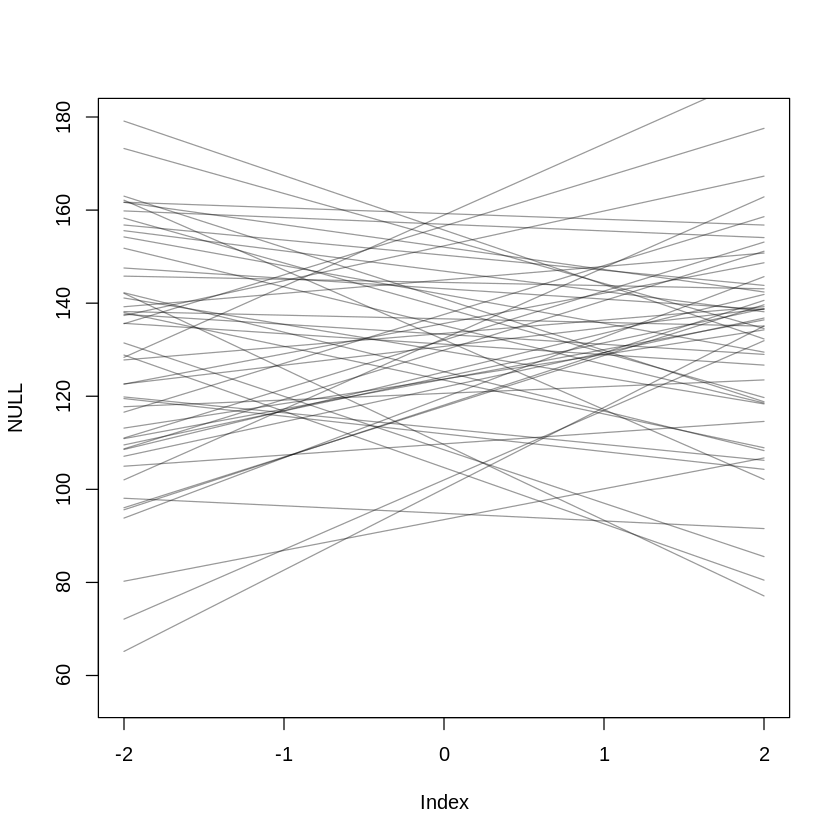

In [109]:
set.seed(10)
prior <- extract.prior( m1 )
xseq <- c(-2,2)
yseq <- c(min(d1$height), max(d1$height))
mu <- link( m1 , post=prior , data=list(age=xseq) )
plot( NULL , xlim=xseq , ylim=yseq )
for ( i in 1:50 ) lines( xseq , mu[i,] , col=col.alpha("black",0.4) )

In [110]:
m2 <- quap(
    alist(
        height ~ dnorm( mu , exp(log_sigma) ) ,
        mu <- a + b1*age + b2*age**2,
        a ~ dnorm( mean(d1$height) , 20 ) ,
        c(b1, b2) ~ dnorm( 0 , 10 ) ,
        log_sigma ~ dnorm( 0 , 1 )
        ) ,
    data=d1 )

precis(m2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,153.482039,0.98672531,151.905061,155.05902
b1,25.829723,0.77653136,24.588676,27.07077
b2,-15.309974,0.70451028,-16.435918,-14.18403
log_sigma,2.459354,0.04265853,2.391177,2.52753


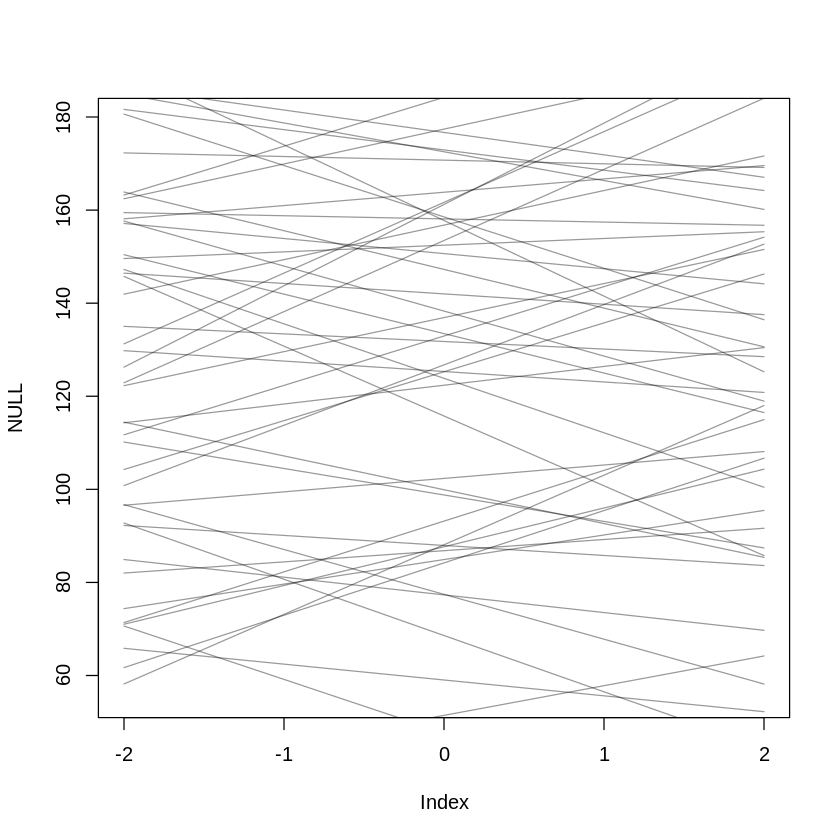

In [111]:
set.seed(10)
prior <- extract.prior( m2 )
xseq <- c(-2,2)
yseq <- c(min(d1$height), max(d1$height))
mu <- link( m2 , post=prior , data=list(age=xseq) )
plot( NULL , xlim=xseq , ylim=yseq )
for ( i in 1:50 ) lines( xseq , mu[i,] , col=col.alpha("black",0.4) )

In [112]:
set.seed(10)
m3 <- quap(
    alist(
        height ~ dnorm( mu , exp(log_sigma) ) ,
        mu <- a + b1*age + b2*age**2 + b3*age**3,
        a ~ dnorm( mean(d1$height) , 20 ) ,
        c(b1, b2, b3) ~ dnorm( 0 , 10 ) ,
        log_sigma ~ dnorm( 0 , 1 )
        ) ,
    data=d1 )

precis(m3)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,158.074071,0.7501961,156.875113,159.273029
b1,11.784599,1.0167069,10.159705,13.409493
b2,-23.634832,0.7053372,-24.762097,-22.507567
b3,7.924721,0.4783827,7.160173,8.689269
log_sigma,2.113949,0.0426758,2.045745,2.182153


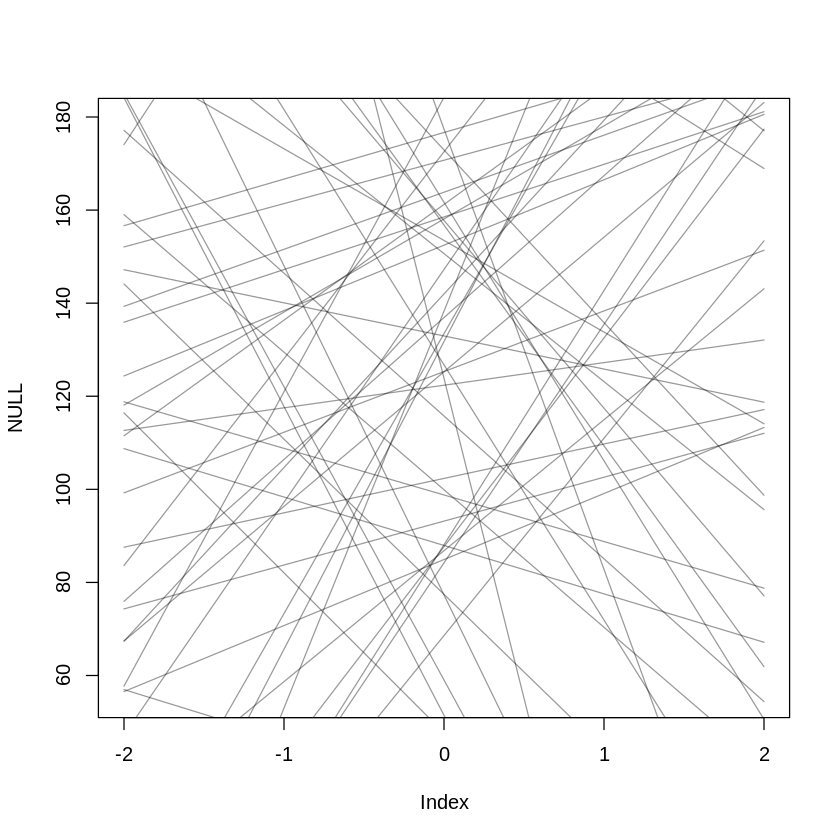

In [113]:
set.seed(10)
prior <- extract.prior( m3 )
xseq <- c(-2,2)
yseq <- c(min(d1$height), max(d1$height))
mu <- link( m3 , post=prior , data=list(age=xseq) )
plot( NULL , xlim=xseq , ylim=yseq )
for ( i in 1:50 ) lines( xseq , mu[i,] , col=col.alpha("black",0.4) )

In [114]:
set.seed(10)
m4 <- quap(
    alist(
        height ~ dnorm( mu , exp(log_sigma) ) ,
        mu <- a + b1*age + b2*age**2 + b3*age**3 + b4*age**4,
        a ~ dnorm( mean(d1$height) , 20 ) ,
        c(b1, b2, b3, b4) ~ dnorm( 0 , 10 ) ,
        log_sigma ~ dnorm( 0 , 1 )
        ) ,
    data=d1 )

precis(m4)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,156.471010,0.76677732,155.245551,157.696468
b1,6.547584,1.33363596,4.416177,8.678992
b2,-18.382616,1.14157819,-20.207078,-16.558153
b3,12.062815,0.85646472,10.694019,13.431611
b4,-2.423078,0.42543327,-3.103003,-1.743154
log_sigma,2.062100,0.04268152,1.993887,2.130314


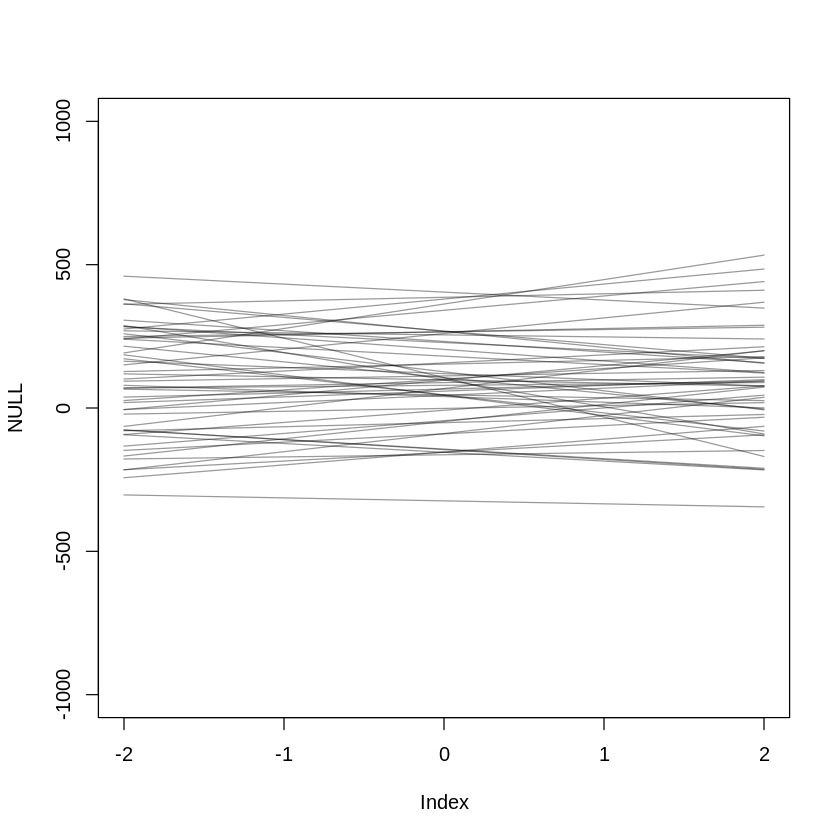

In [129]:
set.seed(10)
prior <- extract.prior( m4 )
xseq <- c(-2,2)
yseq <- c(-1000, 1000)
mu <- link( m4 , post=prior , data=list(age=xseq) )
plot( NULL , xlim=xseq , ylim=yseq )
for ( i in 1:50 ) lines( xseq , mu[i,] , col=col.alpha("black",0.4) )

In [116]:
set.seed(10)
m5 <- quap(
    alist(
        height ~ dnorm( mu , exp(log_sigma) ) ,
        mu <- a + b1*age + b2*age**2 + b3*age**3 + b4*age**4 + b5*age**5,
        a ~ dnorm( mean(d1$height) , 20 ) ,
        c(b1, b2, b3, b4, b5) ~ dnorm( 0 , 10 ) ,
        log_sigma ~ dnorm( 0 , 1 )
        ) ,
    data=d1 )

precis(m5)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,156.0386386,0.8787790,154.6341800,157.443097
b1,7.0432887,1.4193087,4.7749594,9.311618
b2,-16.4427832,2.2392515,-20.0215397,-12.864027
b3,11.1869352,1.2176462,9.2409014,13.132969
b4,-3.3903836,1.0506749,-5.0695650,-1.711202
b5,0.4075317,0.4042202,-0.2384903,1.053554
log_sigma,2.0616794,0.0427002,1.9934362,2.129923


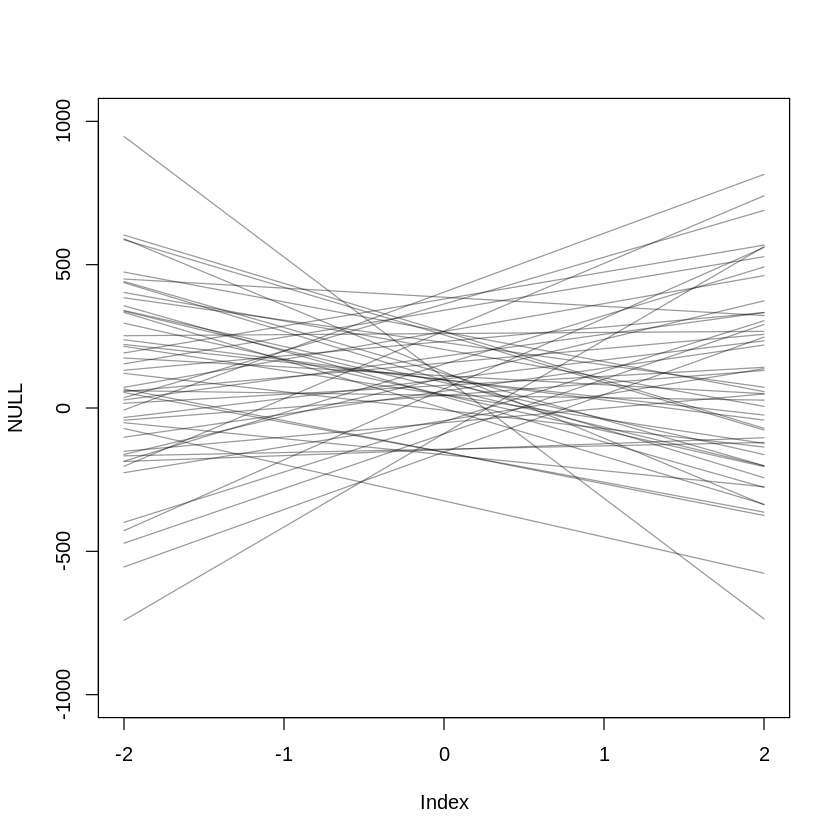

In [128]:
set.seed(10)
prior <- extract.prior( m5 )
xseq <- c(-2,2)
yseq <- c(-1000, 1000)
mu <- link( m5 , post=prior , data=list(age=xseq) )
plot( NULL , xlim=xseq , ylim=yseq )
for ( i in 1:50 ) lines( xseq , mu[i,] , col=col.alpha("black",0.4) )

In [118]:
set.seed(10)
m6 <- quap(
    alist(
        height ~ dnorm( mu , exp(log_sigma) ) ,
        mu <- a + b1*age + b2*age**2 + b3*age**3 + b4*age**4 + b5*age**5 + b6*age**6,
        a ~ dnorm( mean(d1$height) , 20 ) ,
        c(b1, b2, b3, b4, b5, b6) ~ dnorm( 0 , 10 ) ,
        log_sigma ~ dnorm( 0 , 1 )
        ) ,
    data=d1 )

precis(m6)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,155.9596106,0.87459559,154.56183793,157.3573833
b1,4.5567708,2.06967385,1.24903224,7.8645093
b2,-15.8407539,2.25626853,-19.44670677,-12.2348010
b3,16.0772632,3.21775185,10.93467426,21.2198521
b4,-4.6152337,1.28497570,-6.66887308,-2.5615944
b5,-1.4492799,1.20149935,-3.36950789,0.4709482
b6,0.6381704,0.38942552,0.01579322,1.2605476
log_sigma,2.0550885,0.04272974,1.98679815,2.1233789


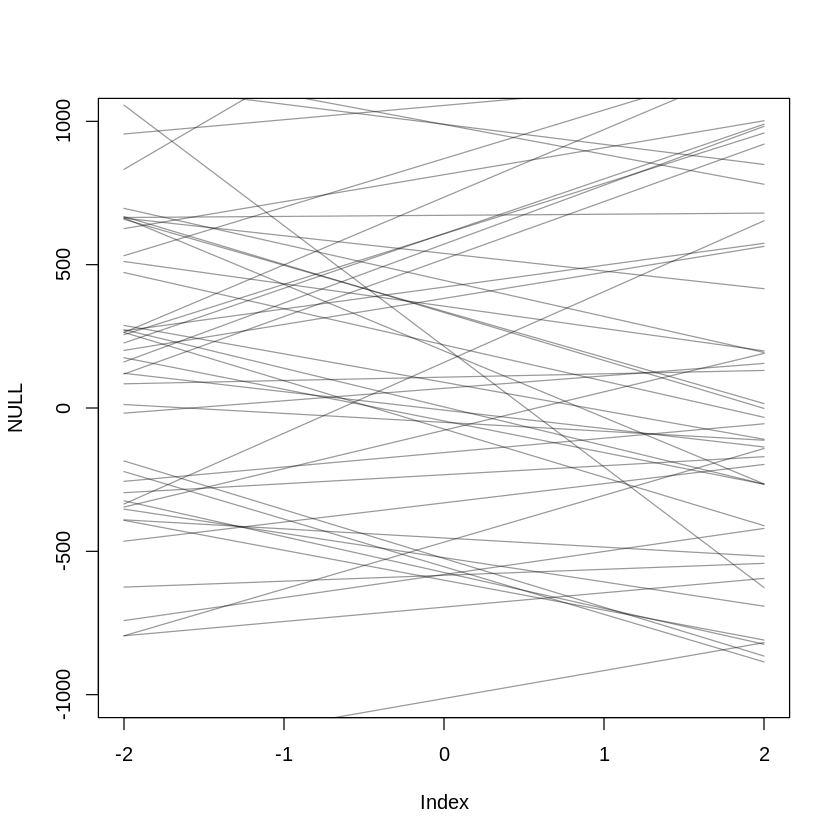

In [123]:
set.seed(10)
prior <- extract.prior( m6 )
xseq <- c(-2,2)
yseq <- c(-1000, 1000)
mu <- link( m6 , post=prior , data=list(age=xseq) )
plot( NULL , xlim=xseq , ylim=yseq )
for ( i in 1:50 ) lines( xseq , mu[i,] , col=col.alpha("black",0.4) )

Question 1

In [130]:
compare (m1, m2, m3, m4, m5, m6)

,WAIC,pWAIC,dWAIC,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m6,1907.215,7.312396,0.000000,5.403120e-01,27.26191,NA
m4,1908.419,6.212719,1.204141,2.959162e-01,27.06266,3.410014
m5,1909.602,6.762776,2.387352,1.637713e-01,27.56230,2.935440
m3,1935.070,5.689565,27.854696,4.831413e-07,24.97445,11.802804
m2,2122.749,6.234635,215.534495,8.509884e-48,25.98564,28.814199
m1,2393.086,3.325273,485.870725,1.687164e-106,22.09795,31.324984


Models 4 and 5 have similar WAICs

Question 2

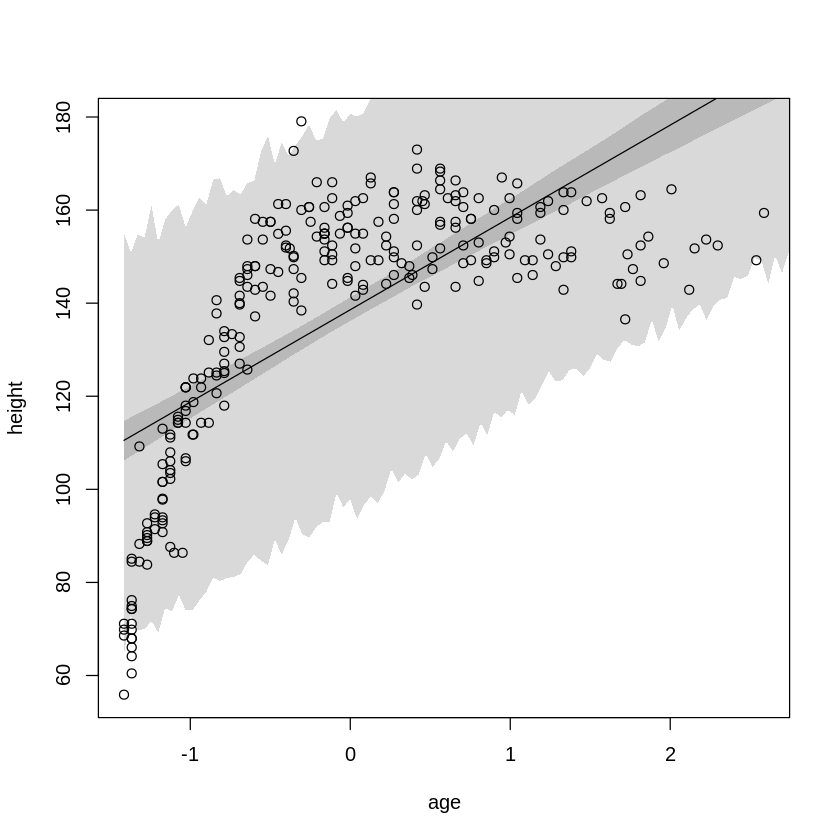

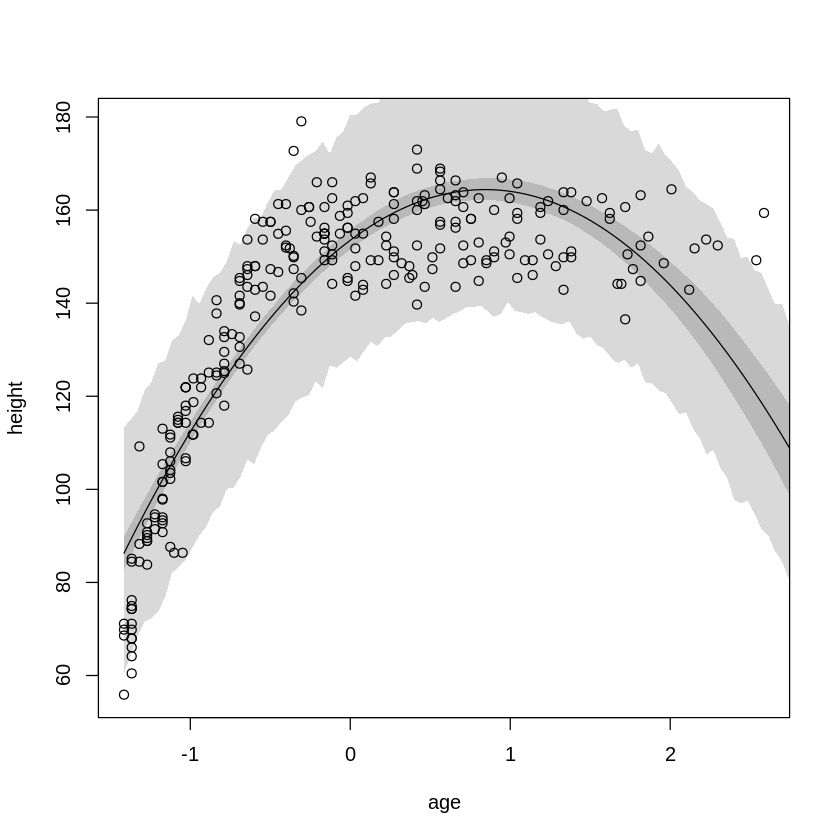

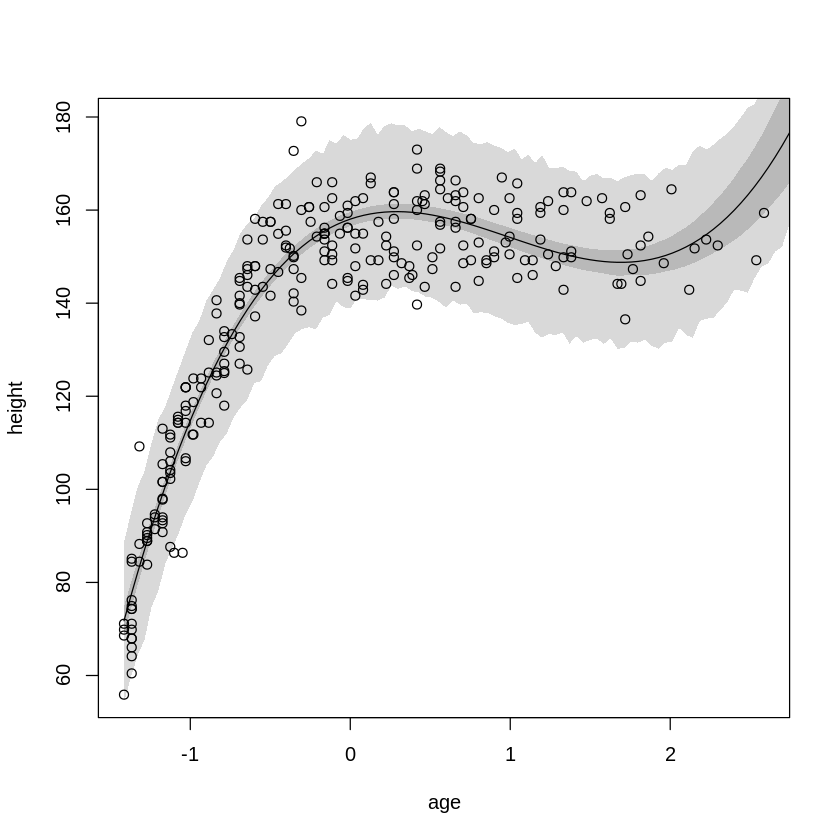

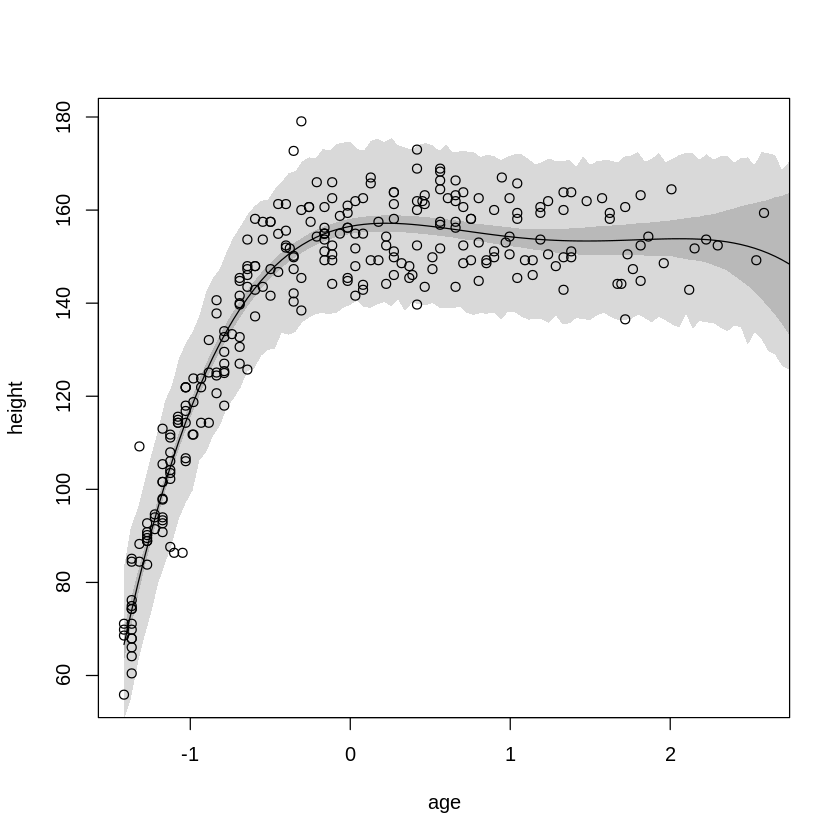

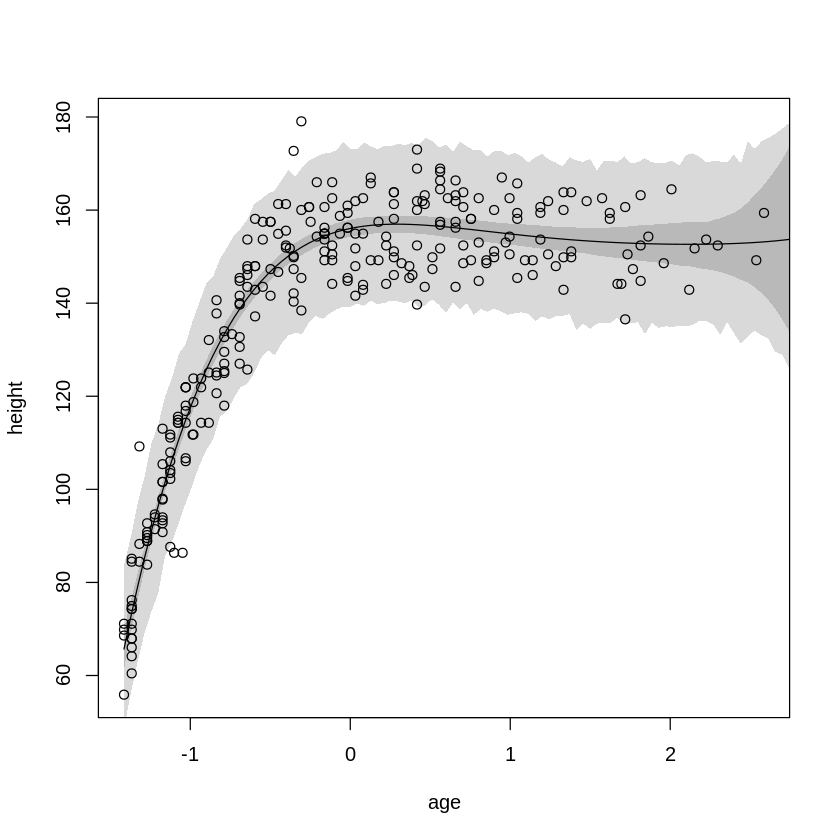

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

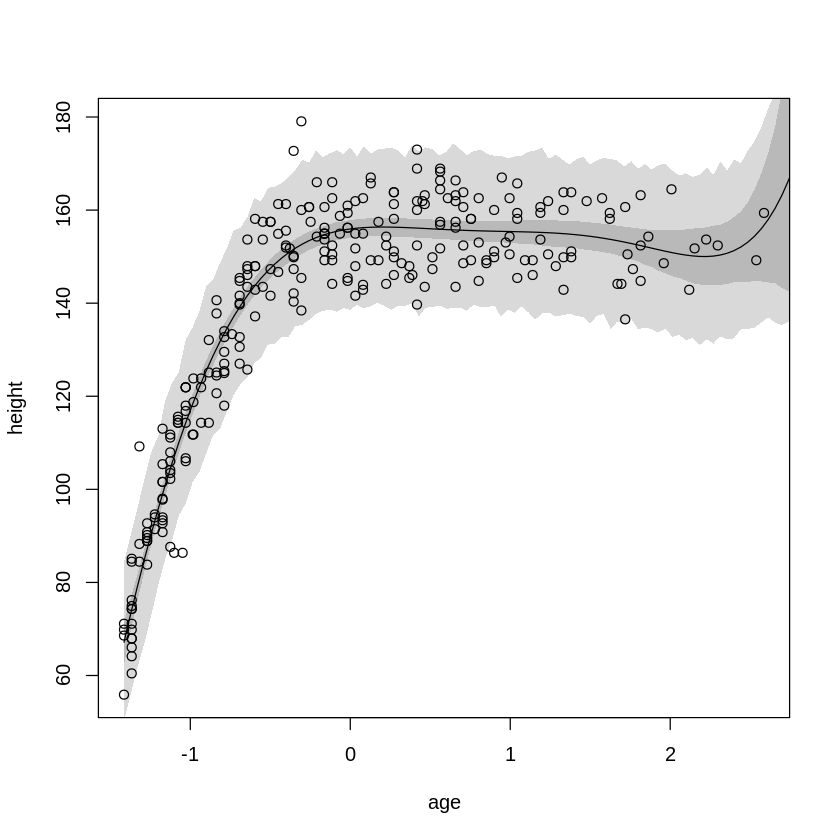

In [131]:
plotFunc <- function(model) {

    post <- extract.samples(model)
    age_seq <- seq( from=min(d$age) , to=max(d$age) , length.out=100 )
    l <- link( model , data=list( age=age_seq ) )
    s <- sim( model, data=list( age=age_seq))
    mu <- apply( l , 2 , mean )
    ci <- apply( l , 2 , PI, prob=0.97 )
    height.ci <- apply( s, 2 , PI, prob=0.97 )
    plot( height ~ age , data=d1 )
    lines( age_seq , mu )
    shade( ci , age_seq )  
    shade( height.ci , age_seq )
        
}


models <- c(m1, m2, m3, m4, m5, m6)

sapply( models, function(x) plotFunc(x) )

The highest order polynomial model (m6) makes the best retrodictions, as would be expected as it has the lowest WAIC.  Again, models 4, 5 and 6 have similar plots and similar WAIC scores.

Question 3

We weigh the models by the WAIC weights to produce an ensemble model (model average).

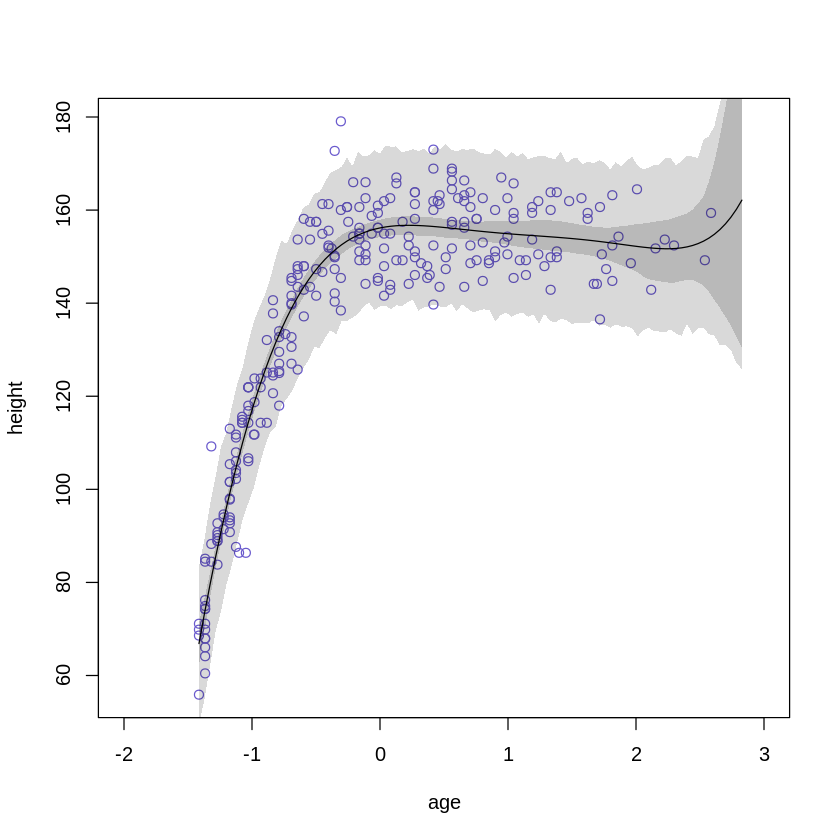

In [132]:
age_seq <- seq( from=min(d$age) , to=max(d$age) , length.out=100 )

m.ensemble <- ensemble( m1, m2, m3, m4,m5, m6 , data=list(age=age_seq) )
mu.mean <- apply( m.ensemble$link , 2 , mean )
mu.ci <- apply( m.ensemble$link , 2 , PI, prob=0.97 )
height.ci <- apply( m.ensemble$sim , 2 , PI, prob=0.97 )

plot( height ~ age , d1 , col="slateblue" , xlim=c(-2,3) )
lines( age_seq , mu.mean )
shade( mu.ci , age_seq )
shade( height.ci , age_seq )

The credible interval of mu (the darker shaded area) expands more quickly for high age values in the ensemble model, reflecting the large differences in predictions among the models (given the model weights, this is dominated by the difference in models m4, m5 and m6).

6H4

Test sample deviance - the deviance on data set d2.

The deviance is -2 * lppd, where lppd is:

sum_i (log (mean_j (p(y_i | theta_j)))), with i'th observation y_i, and the j'th sample of the parameter space.

In [133]:
models <- c(m1, m2, m3, m4, m5, m6)

In [134]:
lppd <- sapply(models, 
                   function(model) {
                        mu <- link( model , data=d2 )
                        mu.mean <- apply(mu, 2, mean)
                        sigma <- exp(coef(model)["log_sigma"])
                        sum( dnorm( d2$height , mu.mean , sigma , log=TRUE ) )
                    } )

In [135]:
deviance <- -2*lppd
names(deviance) <- c("m1", "m2", "m3", "m4", "m5", "m6")

In [136]:
deviance

m1       m2       m3       m4       m5       m6 
2426.344 2172.906 1955.070 1893.306 1894.465 1906.075

6H5

In [137]:
c <- compare(m1, m2, m3, m4, m5, m6)
c

,WAIC,pWAIC,dWAIC,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m6,1907.551,7.401073,0.0000000,4.610786e-01,27.26038,NA
m4,1907.875,5.941052,0.3248555,3.919526e-01,26.97938,3.408907
m5,1909.837,6.892012,2.2867033,1.469683e-01,27.66378,2.870135
m3,1934.901,5.566781,27.3505959,5.304794e-07,24.76878,11.913076
m2,2123.151,6.396677,215.6002538,7.027077e-48,26.24732,29.032977
m1,2392.930,3.213509,485.3796207,1.840473e-106,22.00775,31.344296


In [138]:
c$WAIC - 2*c$pWAIC

[1] 1892.748 1895.993 1896.053 1923.768 2110.357 2386.503

The last line approximates the deviance by subtracting (twice) the penalty term from the WAIC (see the definition of WAIC).

In [139]:
deviance - min(deviance)

m1         m2         m3         m4         m5         m6 
533.037829 279.600669  61.764658   0.000000   1.159471  12.769182

The deviance ranks m4 the best and m6 performs significantly worse than the corresponding WAIC score.

WAIC does a good job of estimating the out-of-sample deviance, although it tends to undersestimate the deviance for the worst performing models.

6H6

In [159]:
m6r <- quap(
        alist(
            height ~ dnorm(mu, exp(log_sigma) ),
            mu <- a + b1*age + b2*age**2 + b3*age**3 + b4*age**4 + b5*age**5 + b6*age**6,
            a ~ dnorm( mean(d1$height) , 20 ) ,
            c(b1, b2, b3, b4, b5, b6) ~ dnorm(0, 5),
            log_sigma ~ dnorm(0, 1) 
            ),
            data = d1)

m6r


Quadratic approximate posterior distribution

Formula:
height ~ dnorm(mu, exp(log_sigma))
mu <- a + b1 * age + b2 * age^2 + b3 * age^3 + b4 * age^4 + b5 * 
    age^5 + b6 * age^6
a ~ dnorm(mean(d1$height), 20)
c(b1, b2, b3, b4, b5, b6) ~ dnorm(0, 5)
log_sigma ~ dnorm(0, 1)

Posterior means:
          a          b1          b2          b3          b4          b5 
155.3809677   6.1714515 -13.9840120  12.8356784  -4.9516036  -0.1287248 
         b6   log_sigma 
  0.3105889   2.0606502 

Log-likelihood: -947.48 

In [154]:
precis(m6r)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,155.3806499,0.84535171,154.029615,156.7316851
b1,6.1716446,1.76383425,3.352697,8.9905924
b2,-13.9832562,2.08464863,-17.314927,-10.6515851
b3,12.8354874,2.67875938,8.554313,17.1166623
b4,-4.9519596,1.16448703,-6.813035,-3.0908844
b5,-0.1286391,1.02413904,-1.765411,1.5081329
b6,0.3106039,0.33415789,-0.223445,0.8446527
log_sigma,2.0606559,0.04304248,1.991866,2.1294461


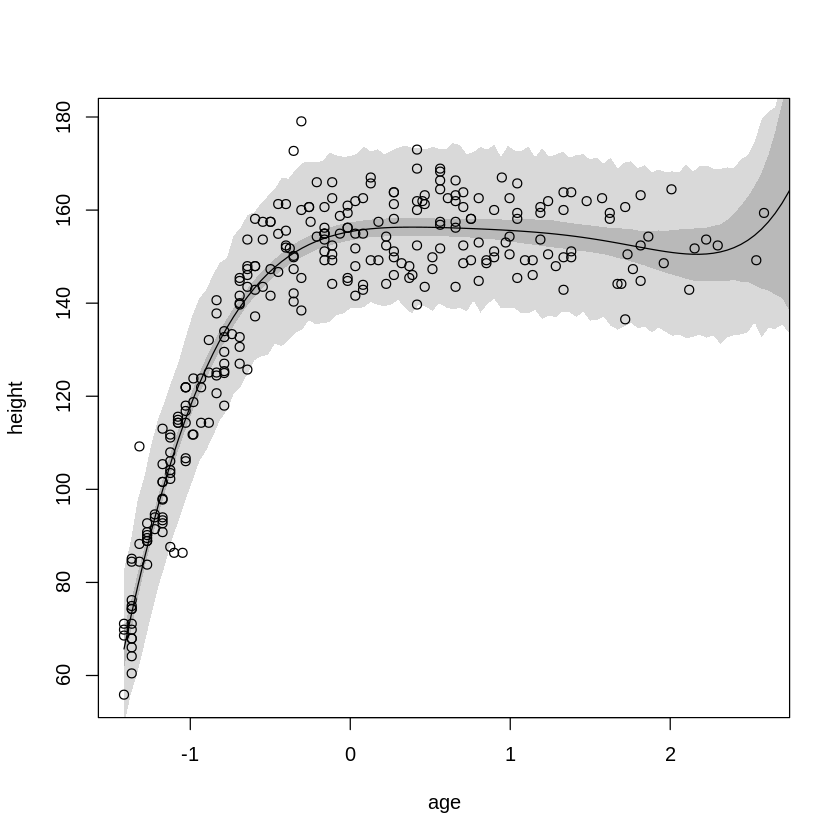

In [152]:
plotFunc(m6r)

In [155]:
mu <- link( m6r , data=d2 )
mu.mean <- apply(mu, 2, mean)
sigma <- exp(coef(m6r)["log_sigma"])
lppd_m6r <- sum( dnorm( d2$height , mu.mean , sigma , log=TRUE ) )
lppd_m6r

[1] -952.9349

In [156]:
(deviance_m6r <- -2*lppd_m6r)

[1] 1905.87

In [157]:
deviance

m1       m2       m3       m4       m5       m6 
2426.344 2172.906 1955.070 1893.306 1894.465 1906.075

In [148]:
compare(m1, m2, m3, m4, m5, m6, m6r)

,WAIC,pWAIC,dWAIC,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m6,1907.301,7.303829,0.0000000,4.532777e-01,27.08723,NA
m4,1908.136,6.074694,0.8357669,2.984557e-01,26.97493,3.339187
m5,1909.717,6.813004,2.4168596,1.353786e-01,27.58823,2.928867
m6r,1910.081,7.183311,2.7802245,1.128876e-01,27.99890,2.608552
m3,1934.964,5.634318,27.6637861,4.459124e-07,24.88726,11.680844
m2,2122.524,6.058054,215.2232464,8.341232e-48,25.94913,28.671061
m1,2392.781,3.171284,485.4807766,1.720098e-106,21.94435,31.126717


The m6r model has a lower deviance than the m6 one as with restrictive priors, overfitting has been limited.  Observing the coefficients of the m6r, the 5th and 6th power coefficients are not significantly different from 0.  Indeed the m4 model has the lowest test sample (out of sample) deviance of all models.

Homework Question 2

In [161]:
library(rethinking)
d <- sim_happiness( seed=1977 , N_years=1000 )
precis(d)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
age,3.300000e+01,18.768883,4.000000,62.000000,▇▇▇▇▇▇▇▇▇▇▇▇▇
married,3.007692e-01,0.458769,0.000000,1.000000,▇▁▁▁▁▁▁▁▁▃
happiness,-1.000070e-16,1.214421,-1.789474,1.789474,▇▅▇▅▅▇▅▇


In [163]:
d2 <- d[ d$age>17 , ] # only adults
d2$A <- ( d2$age - 18 ) / ( 65 - 18 )

d2$mid <- d2$married + 1

In [164]:
m6.9 <- quap(
    alist(
    happiness ~ dnorm( mu , sigma ),
    mu <- a[mid] + bA*A,
    a[mid] ~ dnorm( 0 , 1 ),
    bA ~ dnorm( 0 , 2 ),
    sigma ~ dexp(1)
    ) , data=d2 )

precis(m6.9,depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a[1],-0.2350877,0.06348986,-0.3365568,-0.1336186
a[2],1.2585517,0.08495989,1.1227694,1.3943340
bA,-0.7490274,0.11320112,-0.9299447,-0.5681102
sigma,0.9897080,0.02255800,0.9536559,1.0257600


In [165]:
m6.10 <- quap(
    alist(
    happiness ~ dnorm( mu , sigma ),
    mu <- a + bA*A,
    a ~ dnorm( 0 , 1 ),
    bA ~ dnorm( 0 , 2 ),
    sigma ~ dexp(1)
    ) , data=d2 )

precis(m6.10)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.649248e-07,0.07675015,-0.1226614,0.1226617
bA,-2.728620e-07,0.13225976,-0.2113769,0.2113764
sigma,1.213188e+00,0.02766080,1.1689803,1.2573949


In [166]:
compare(m6.9, m6.10)

,WAIC,pWAIC,dWAIC,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m6.9,2713.938,3.706348,0.0000,1.000000e+00,37.54076,NA
m6.10,3101.906,2.340445,387.9678,5.673701e-85,27.74379,35.39641


In [168]:
compare(m6.9, m6.10, func=LOO)

,LOO,pLOO,dLOO,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m6.9,2713.986,3.742327,0.0000,1.000000e+00,37.50641,NA
m6.10,3102.029,2.410655,388.0426,5.465508e-85,27.67919,35.24255


Model m6.9, which explains a person's happiness controlling for both age and marriage status has the lowest WAIC and LOO compared to model m6.10, which only controls for age, and not for marriage status.  This suggests that model m6.9 would make better predictions.  However, as discussed in Chapter 6, model m6.10 provides the correct causal inference about the influence of age on happiness (this is known because the simulation is known to us).  Marriage is a collider, so when we condition on it in m6.9, it opens a backdoor path between age and happiness.  It should be expected that model m6.9 would make better predictions because it has additional parameters (to control for the marriage status) and can (over)fit the model more.  Indeed the effective parameter measures 'pWAIC' and 'pLOO' indicate the additional parameter.

From the solutions:
    "The model that produces the invalid inference, m6.9 , is expected to predict
much better. And it would. This is because the collider path does convey
actual association. We simply end up mistaken about the causal inference.
We should not use WAIC (or LOO) to choose among models, unless we have
some clear sense of the causal model. These criteria will happily favor confounded models."

Homework Question 3

In [172]:
data(foxes)

d = foxes
head(d)

group,avgfood,groupsize,area,weight
<int>,<dbl>,<int>,<dbl>,<dbl>
1,0.37,2,1.09,5.02
1,0.37,2,1.09,2.84
2,0.53,2,2.05,5.33
2,0.53,2,2.05,6.07
3,0.49,2,2.12,5.85
3,0.49,2,2.12,3.25


In [173]:
d$F <- scale( d$avgfood )
d$G <- scale( d$groupsize )
d$A <- scale( d$area )
d$W <- scale( d$weight )
head(d)

group,avgfood,groupsize,area,weight,F,G,A,W
<int>,<dbl>,<int>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
1,0.37,2,1.09,5.02,-1.924829,-1.524089,-2.239596,0.4141347
1,0.37,2,1.09,2.84,-1.924829,-1.524089,-2.239596,-1.4270464
2,0.53,2,2.05,5.33,-1.118035,-1.524089,-1.205508,0.6759540
2,0.53,2,2.05,6.07,-1.118035,-1.524089,-1.205508,1.3009421
3,0.49,2,2.12,5.85,-1.319734,-1.524089,-1.130106,1.1151348
3,0.49,2,2.12,3.25,-1.319734,-1.524089,-1.130106,-1.0807692


In [175]:
m1 <- quap(
    alist(
    W ~ dnorm( mu , sigma ),
    mu <- a + b_F*F + b_G*G + b_A*A,
    a ~ dnorm( 0 , 1 ),
    c(b_F, b_G, b_A) ~ dnorm( 0 , 2 ),
    sigma ~ dexp(1)
    ) , data=d )

precis(m1)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.274528e-07,0.08593730,-0.137344269,0.1373445
b_F,4.099391e-01,0.23980818,0.026679276,0.7931989
b_G,-7.779878e-01,0.20095190,-1.099147722,-0.4568278
b_A,3.007535e-01,0.18564435,0.004057923,0.5974490
sigma,9.290098e-01,0.06063091,0.832109927,1.0259097


In [176]:
m2 <- quap(
    alist(
    W ~ dnorm( mu , sigma ),
    mu <- a + b_F*F + b_G*G,
    a ~ dnorm( 0 , 1 ),
    c(b_F, b_G) ~ dnorm( 0 , 2 ),
    sigma ~ dexp(1)
    ) , data=d )

precis(m2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,4.115727e-08,0.08688023,-0.1388514,0.1388514
b_F,6.279616e-01,0.20052565,0.3074829,0.9484403
b_G,-7.256980e-01,0.20052576,-1.0461769,-0.4052191
sigma,9.392804e-01,0.06129768,0.8413149,1.0372459


In [177]:
m3 <- quap(
    alist(
    W ~ dnorm( mu , sigma ),
    mu <- a + b_G*G + b_A*A,
    a ~ dnorm( 0 , 1 ),
    c(b_G, b_A) ~ dnorm( 0 , 2 ),
    sigma ~ dexp(1)
    ) , data=d )

precis(m3)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-4.251358e-05,0.08701982,-0.1391170,0.1390320
b_G,-5.563374e-01,0.15549527,-0.8048489,-0.3078259
b_A,4.790094e-01,0.15549520,0.2304981,0.7275208
sigma,9.408010e-01,0.06139314,0.8426829,1.0389191


In [178]:
m4 <- quap(
    alist(
    W ~ dnorm( mu , sigma ),
    mu <- a + b_F*F,
    a ~ dnorm( 0 , 1 ),
    b_F ~ dnorm( 0 , 2 ),
    sigma ~ dexp(1)
    ) , data=d )

precis(m4)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,3.324684e-07,0.09163814,-0.1464551,0.1464558
b_F,-2.498561e-02,0.09232606,-0.1725405,0.1225693
sigma,9.911434e-01,0.06465848,0.8878066,1.0944801


In [179]:
m5 <- quap(
    alist(
    W ~ dnorm( mu , sigma ),
    mu <- a + b_A*A,
    a ~ dnorm( 0 , 1 ),
    b_A ~ dnorm( 0 , 2 ),
    sigma ~ dexp(1)
    ) , data=d )

precis(m5)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-0.0000133809,0.09168349,-0.1465413,0.1465145
b_A,0.0195334864,0.09237204,-0.1280949,0.1671619
sigma,0.9916380089,0.06472701,0.8881918,1.0950843


In [180]:
compare(m1, m2, m3, m4, m5)

,WAIC,pWAIC,dWAIC,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m1,323.6123,5.314708,0.0000000,0.396386901,16.87063,NA
m2,324.0590,4.178666,0.4466605,0.317050319,16.83755,3.843208
m3,324.2926,4.061533,0.6803486,0.282087267,16.15394,4.117533
m4,333.8905,2.630204,10.2781510,0.002324059,13.79999,8.575012
m5,334.0448,2.797315,10.4324950,0.002151453,13.79519,8.635576


The models with the same number of parameters have very similar WAICs, and the models with more parameters have better (lower) WAICs.  The standard error of the score differences (dSE) are larger than the differences (dWAIC) of models m1, m2 and m3, and almost cover the differences of models m4 and m5.  This suggests that the standard error is so large that none of the models stand out as being particularly better than the others for prediction.  See the plot below for visualization:

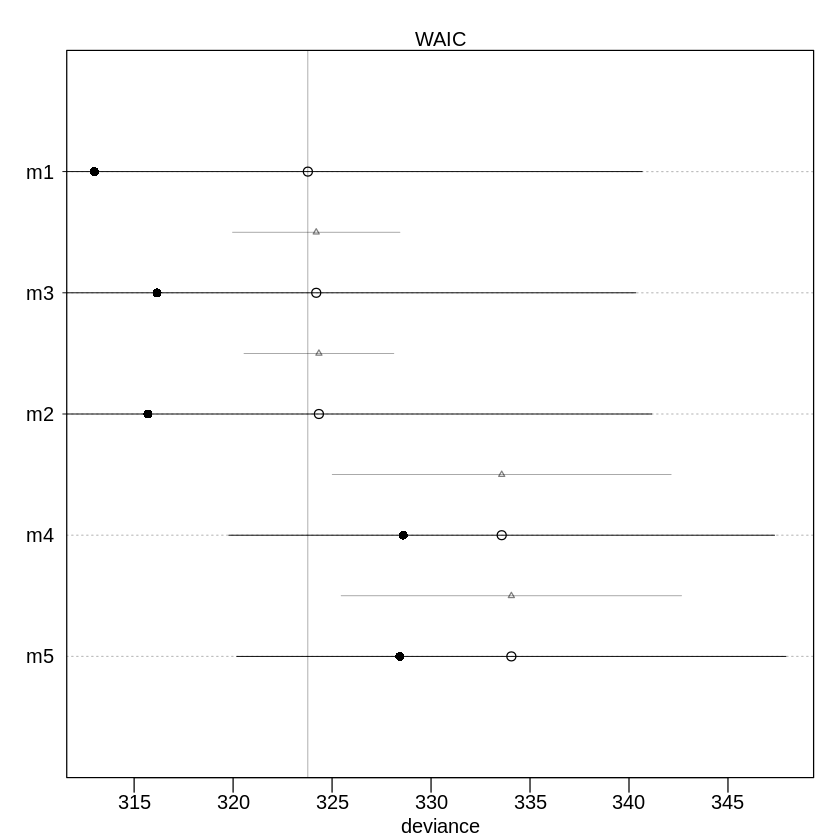

In [181]:
plot( compare( m1, m2, m3 , m4 , m5 ) )

In [182]:
coeftab(m1, m2, m3, m4, m5)

      m1      m2      m3      m4      m5     
a           0       0       0       0       0
b_F      0.41    0.63      NA   -0.02      NA
b_G     -0.78   -0.73   -0.56      NA      NA
b_A      0.30      NA    0.48      NA    0.02
sigma    0.93    0.94    0.94    0.99    0.99
nobs      116     116     116     116     116